In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report, ConfusionMatrixDisplay, average_precision_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc, PrecisionRecallDisplay
import optuna

Content

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

# import file

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# basic eda

In [3]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [4]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [5]:
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

array([[<Axes: title={'center': 'Time'}>, <Axes: title={'center': 'V1'}>,
        <Axes: title={'center': 'V2'}>, <Axes: title={'center': 'V3'}>,
        <Axes: title={'center': 'V4'}>, <Axes: title={'center': 'V5'}>],
       [<Axes: title={'center': 'V6'}>, <Axes: title={'center': 'V7'}>,
        <Axes: title={'center': 'V8'}>, <Axes: title={'center': 'V9'}>,
        <Axes: title={'center': 'V10'}>, <Axes: title={'center': 'V11'}>],
       [<Axes: title={'center': 'V12'}>, <Axes: title={'center': 'V13'}>,
        <Axes: title={'center': 'V14'}>, <Axes: title={'center': 'V15'}>,
        <Axes: title={'center': 'V16'}>, <Axes: title={'center': 'V17'}>],
       [<Axes: title={'center': 'V18'}>, <Axes: title={'center': 'V19'}>,
        <Axes: title={'center': 'V20'}>, <Axes: title={'center': 'V21'}>,
        <Axes: title={'center': 'V22'}>, <Axes: title={'center': 'V23'}>],
       [<Axes: title={'center': 'V24'}>, <Axes: title={'center': 'V25'}>,
        <Axes: title={'center': 'V26'}>, <

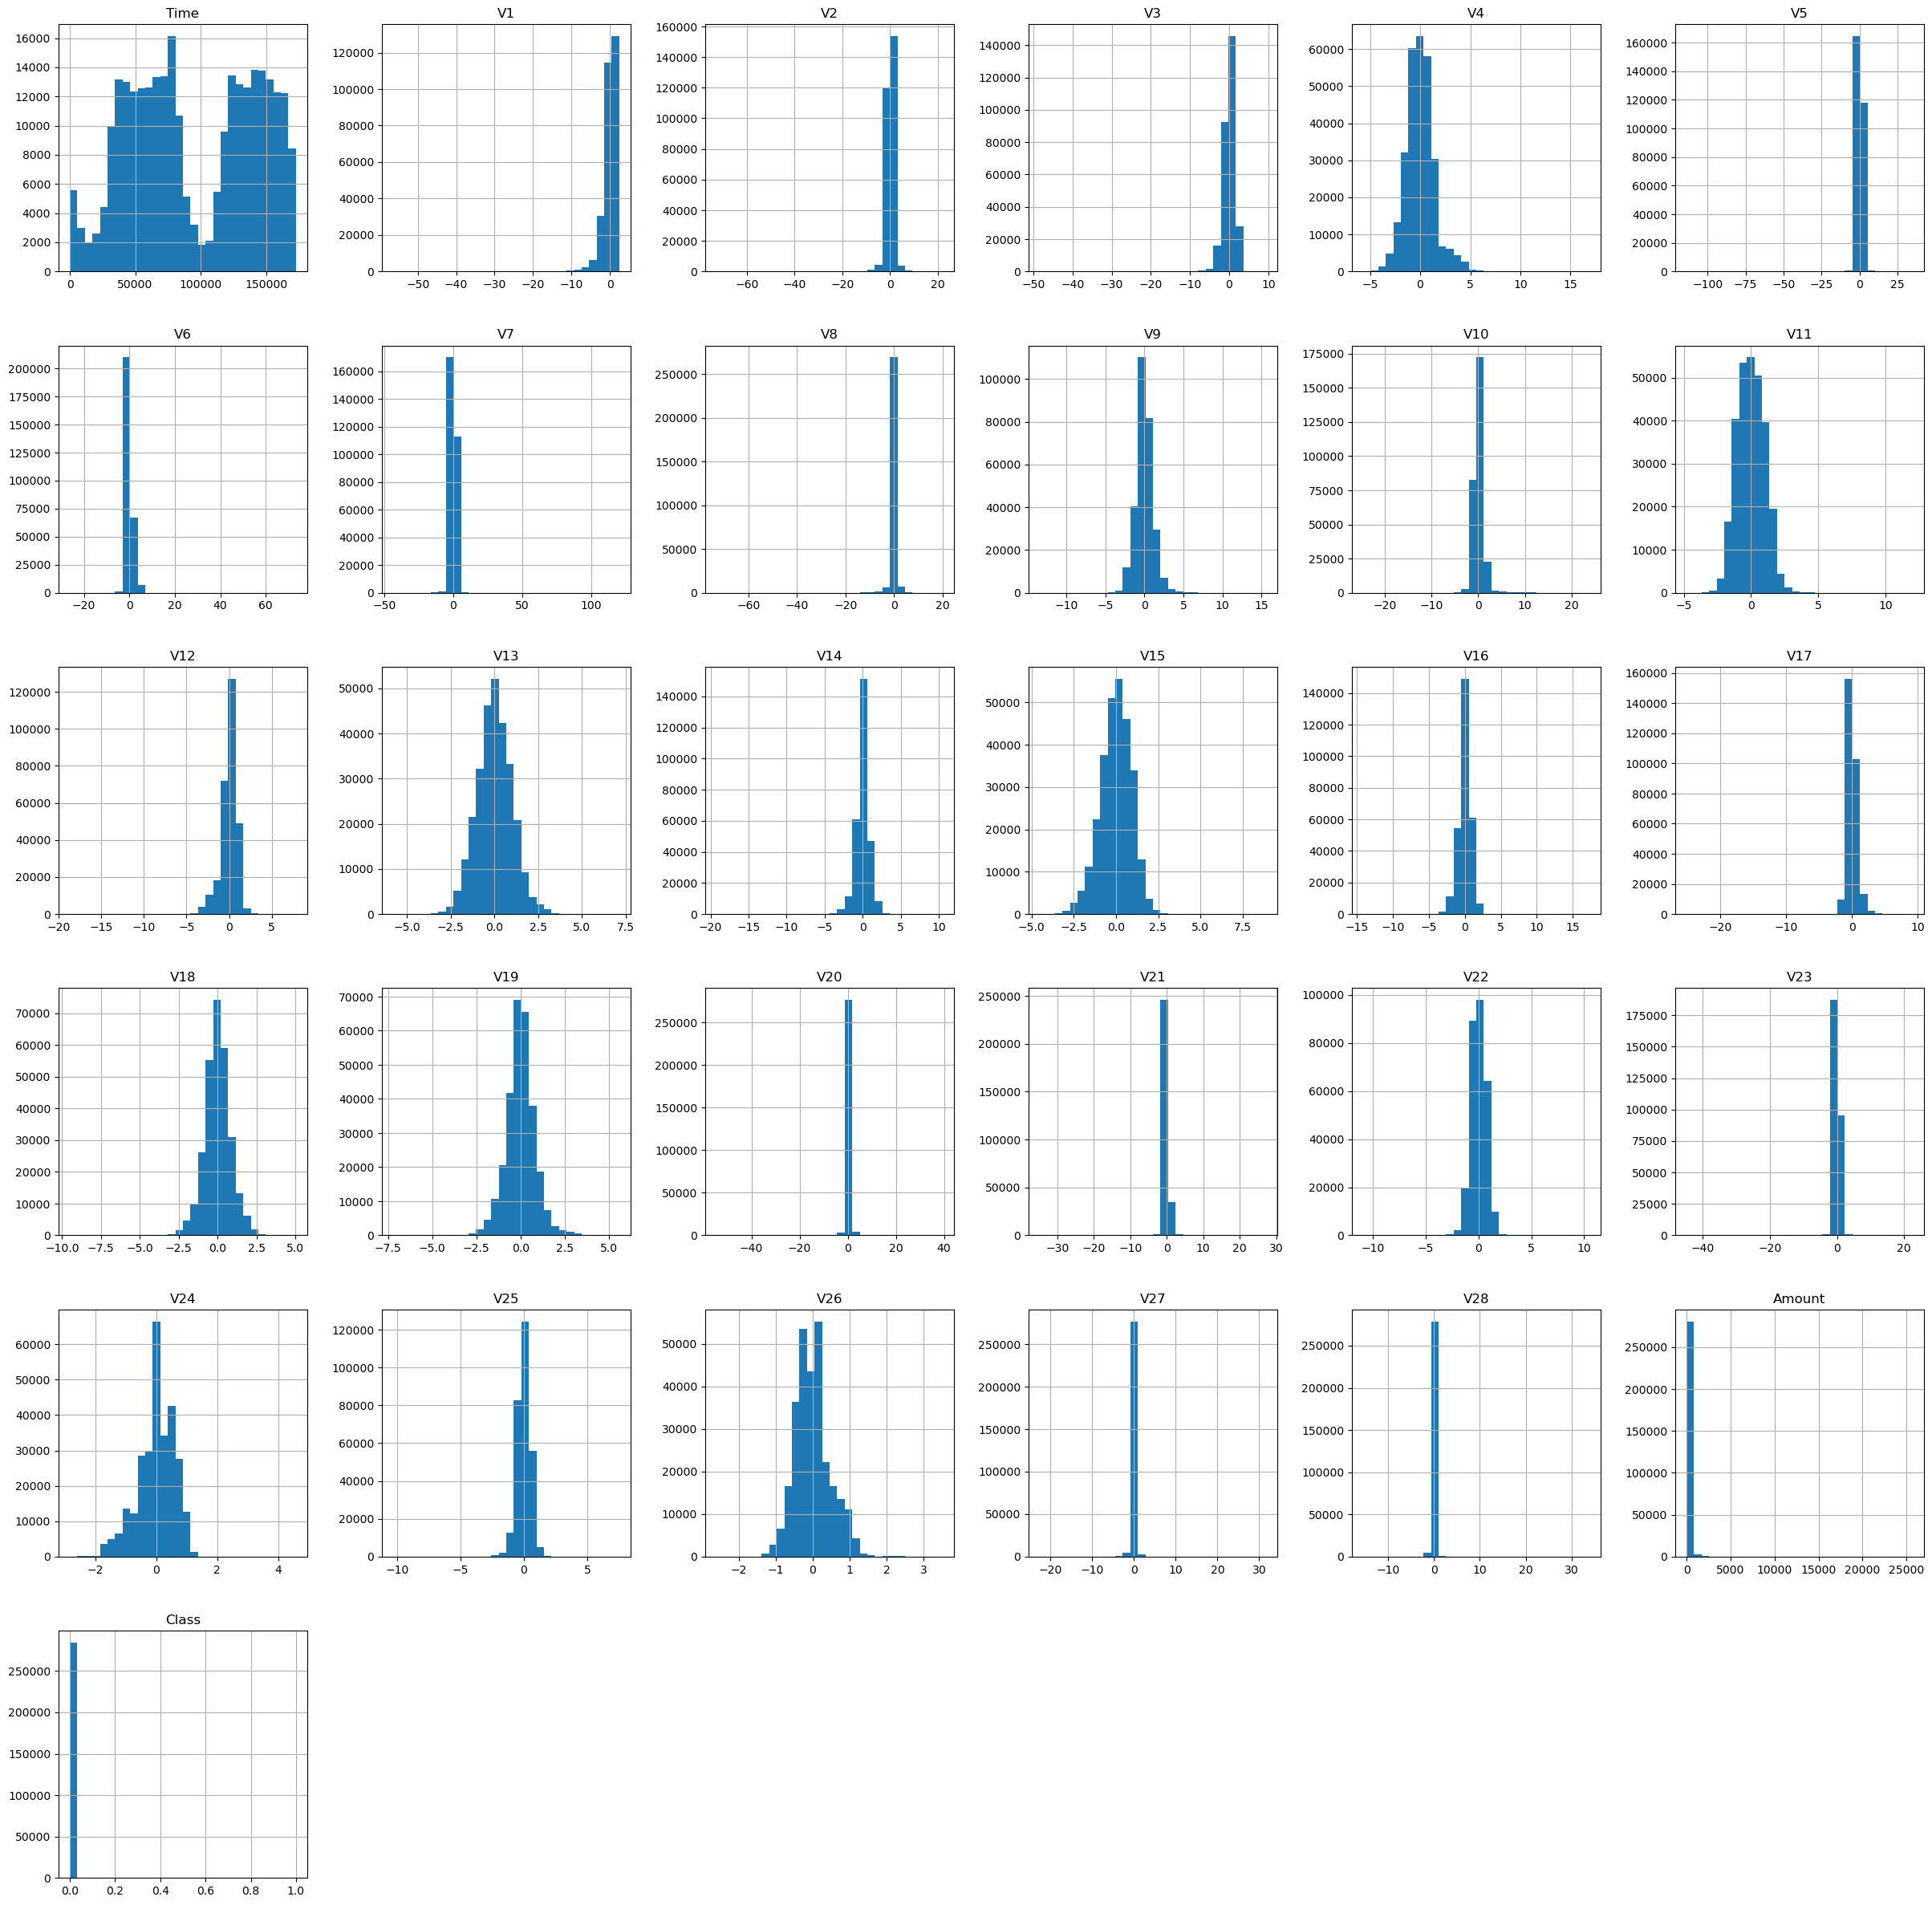

In [6]:
df.hist(bins=30, figsize= (30,30))

In [7]:
df['Amount'].describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

In [8]:
scaler = RobustScaler()
scaler2 = MinMaxScaler()

# def scaling(df):
#     df['Amount'] = scaler.fit_transform(df['Amount'].to_numpy().reshape(-1,1))
#     df['Time'] = scaler2.fit_transform(df['Time'].to_numpy().reshape(-1,1))
#     return df

Class
0    284315
1       492
Name: count, dtype: int64


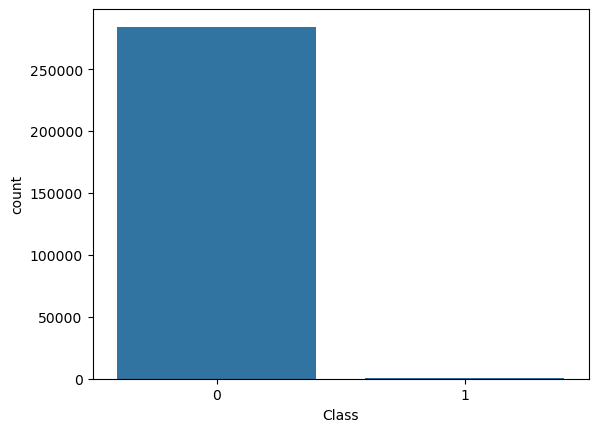

In [9]:
sns.countplot(df, x = 'Class')
print(df['Class'].value_counts())
plt.show()

In [10]:
print(df['Class'].value_counts()[0]/len(df)*100)
print(df['Class'].value_counts()[1]/len(df)*100)

99.82725143693798
0.1727485630620034


<Axes: >

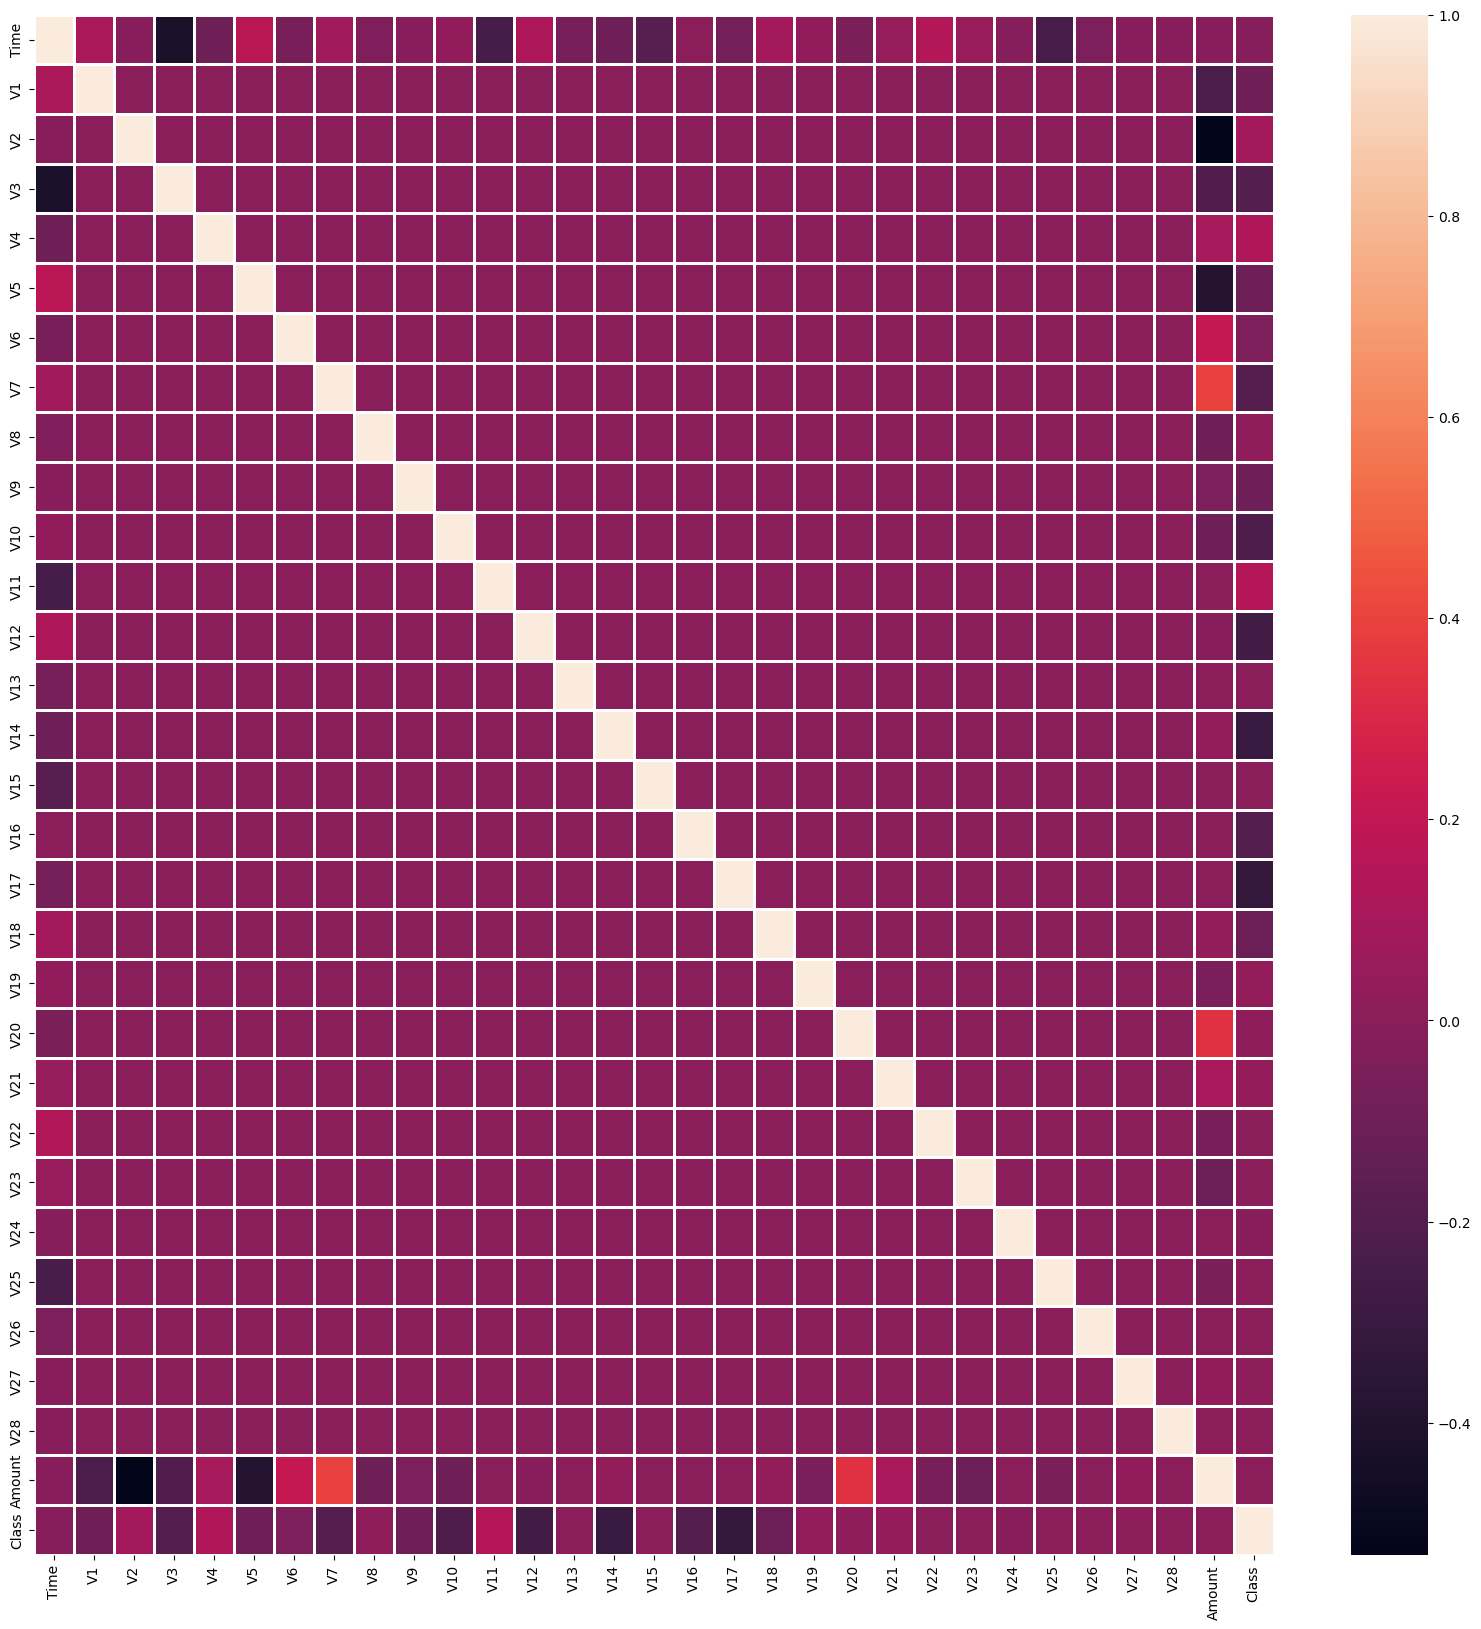

In [11]:
plt.figure(figsize = (20,20))
sns.heatmap(df.corr(), linewidths= 1)

In [12]:
df.corr()['Class']

Time     -0.012323
V1       -0.101347
V2        0.091289
V3       -0.192961
V4        0.133447
V5       -0.094974
V6       -0.043643
V7       -0.187257
V8        0.019875
V9       -0.097733
V10      -0.216883
V11       0.154876
V12      -0.260593
V13      -0.004570
V14      -0.302544
V15      -0.004223
V16      -0.196539
V17      -0.326481
V18      -0.111485
V19       0.034783
V20       0.020090
V21       0.040413
V22       0.000805
V23      -0.002685
V24      -0.007221
V25       0.003308
V26       0.004455
V27       0.017580
V28       0.009536
Amount    0.005632
Class     1.000000
Name: Class, dtype: float64

# training and evaluation

1. base model
2. deal with the imbalance dataset (imblearn, smote)
    - undersampling: remove random record from majority class. good if have a lot of data.  can cause loss of information
    - oversampling: duplicates random record from minority class. good if dont have a lot of data. can cause overfitting and poor generalization

## 1. base model

In [13]:
from sklearn.model_selection import train_test_split

X , y = df.drop('Class', axis= 1), df['Class']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size= 0.3, stratify= y, random_state= 2908)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size= 0.333, stratify= y_temp, random_state= 2908)

In [14]:
print(y_train.value_counts()[1]/len(y_train)*100)
print(y_val.value_counts()[1]/len(y_val)*100)
print(y_test.value_counts()[1]/len(y_val)*100)

0.17254870488152324
0.17371468678715565
0.08597999649061239


In [15]:
# X_train = scaling(X_train)
# X_val = scaling(X_val)
# X_test = scaling(X_test)

In [16]:
X_train1 = X_train.copy()
X_val1 = X_val.copy()

In [17]:
X_train1['Amount'] = scaler.fit_transform(X_train1['Amount'].to_numpy().reshape(-1,1))
X_val['Amount'] = scaler.transform(X_val['Amount'].to_numpy().reshape(-1,1))

X_train1['Time'] = scaler2.fit_transform(X_train1['Time'].to_numpy().reshape(-1,1))
X_val1['Time'] = scaler2.transform(X_val1['Time'].to_numpy().reshape(-1,1))

In [18]:
# import joblib

# joblib.dump(scaler, 'amount_scaler.pkl')
# joblib.dump(scaler2, 'time_scaler.pkl')

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

lr = LogisticRegression(max_iter=10000, random_state= 2908)
rf = RandomForestClassifier(random_state= 2908)
xgb = XGBClassifier(random_state = 2908)
lgbm = LGBMClassifier(random_state = 2908)
cb = CatBoostClassifier(verbose= 10, random_state = 2908)

clfs = [lr, rf, xgb, lgbm, cb]

In [20]:
def result_clsf(clf, X_train, y_train, X_val, y_val):
    
    clf.fit(X_train, y_train)
    y_val_pred = clf.predict(X_val)
    
    print(clf)
    # Precision: TP/(TP+FP)
    print("Precision:", precision_score(y_val, y_val_pred))
    # Recall: TP/(TP+FN)
    print("Recall:", recall_score(y_val, y_val_pred))
    # F1 Score: 2*recall*precision/(recall+precision) ie. balance between precision and recall
    print("F1 Score:", f1_score(y_val, y_val_pred ))
    
    fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)
    print("AUC :", auc(fpr, tpr))
    print(classification_report(y_val, y_val_pred, target_names = ['not fraud', 'fraud']))
    print(confusion_matrix(y_val, y_val_pred))
    # plt.show()

In [21]:
for clf in clfs:
    result_clsf(clf, X_train1, y_train, X_val1, y_val)

LogisticRegression(max_iter=10000, random_state=2908)
Precision: 0.007252519544127343
Recall: 0.7777777777777778
F1 Score: 0.01437103396789847
AUC : 0.7962556077020579
              precision    recall  f1-score   support

   not fraud       1.00      0.81      0.90     56891
       fraud       0.01      0.78      0.01        99

    accuracy                           0.81     56990
   macro avg       0.50      0.80      0.46     56990
weighted avg       1.00      0.81      0.90     56990

[[46351 10540]
 [   22    77]]
RandomForestClassifier(random_state=2908)
Precision: 0.948051948051948
Recall: 0.7373737373737373
F1 Score: 0.8295454545454545
AUC : 0.8686517137414468
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.95      0.74      0.83        99

    accuracy                           1.00     56990
   macro avg       0.97      0.87      0.91     56990
weighted avg       1.00      1.00      1.00     56

since we want high recall, we continue with xgbclassifier.

## 2. deal with imbalance dataset

### before undersample and oversample

In [22]:
xgb = XGBClassifier(
    # learning_rate = 0.5,
    # max_depth = 4,
    # n_estimator = 200,
    # early_stopping_rounds=10,
    # eval_metric= roc_curve,
    random_state = 2908)

xgb.fit(X_train1,y_train,eval_set=[(X_val1,y_val)],verbose = 10)

y_pred = xgb.predict(X_val1)

# Precision: TP/(TP+FP)
print("Precision:", precision_score(y_val, y_pred))
# Recall: TP/(TP+FN)
print("Recall:", recall_score(y_val, y_pred))
# F1 Score: 2*recall*precision/(recall+precision) ie. balance between precision and recall
print("F1 Score:", f1_score(y_val, y_pred))
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
print("AUC :", auc(fpr, tpr))
print(classification_report(y_val, y_pred, target_names = ['not fraud', 'fraud']))
cfs_mat = confusion_matrix(y_val, y_pred)
print(cfs_mat)

[0]	validation_0-logloss:0.09446
[10]	validation_0-logloss:0.00683
[20]	validation_0-logloss:0.00293
[30]	validation_0-logloss:0.00286
[40]	validation_0-logloss:0.00294
[50]	validation_0-logloss:0.00304
[60]	validation_0-logloss:0.00310
[70]	validation_0-logloss:0.00317
[80]	validation_0-logloss:0.00318
[90]	validation_0-logloss:0.00324
[99]	validation_0-logloss:0.00326
Precision: 0.926829268292683
Recall: 0.7676767676767676
F1 Score: 0.8397790055248618
AUC : 0.883785651420251
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.93      0.77      0.84        99

    accuracy                           1.00     56990
   macro avg       0.96      0.88      0.92     56990
weighted avg       1.00      1.00      1.00     56990

[[56885     6]
 [   23    76]]


In [23]:
def plot_auprc(recall, precision):

    auprc = auc(recall, precision)

    plt.figure(figsize=(8, 6))
    PrecisionRecallDisplay(precision=precision, recall=recall).plot()
    plt.title(f'Precision-Recall Curve (AUC = {auprc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

    # Print the AUPRC
    print(f"Area Under the Precision-Recall Curve (AUPRC): {auprc:.2f}")

def plot_roc_auc(fpr, tpr):
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'(AUC = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.show()

In [24]:
res_df = pd.DataFrame()

In [25]:
def add_res(res_df, dataset, X_train, X_val, y_train, y_val):
    xgb = XGBClassifier(random_state = 2908)    
    xgb.fit(X_train,y_train,eval_set=[(X_val,y_val)], verbose= 20)

    y_pred = xgb.predict(X_val)
    y_pred_prob = xgb.predict_proba(X_val)[:,1]
    fpr, tpr, thresholds = roc_curve(y_val, y_pred)
    precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)
    
    plot_auprc(recall, precision)
    plot_roc_auc(fpr,tpr)
    print(confusion_matrix(y_val, y_pred))
    
    print(classification_report(y_val, y_pred, target_names = ['not fraud', 'fraud']))
    auprc = auc(recall, precision)
    add_df = pd.DataFrame(
        {'type': [dataset],
         'accuracy': accuracy_score(y_val, y_pred),
         "Precision": precision_score(y_val, y_pred),
         "Recall": recall_score(y_val, y_pred),
         "F1 Score": f1_score(y_val, y_pred),
         'auc': auc(fpr, tpr),
         'aucprc': auprc
         }
    )
    res_df = pd.concat([res_df, add_df])
    return res_df


[0]	validation_0-logloss:0.09446
[20]	validation_0-logloss:0.00296
[40]	validation_0-logloss:0.00299
[60]	validation_0-logloss:0.00321
[80]	validation_0-logloss:0.00331
[99]	validation_0-logloss:0.00340


<Figure size 800x600 with 0 Axes>

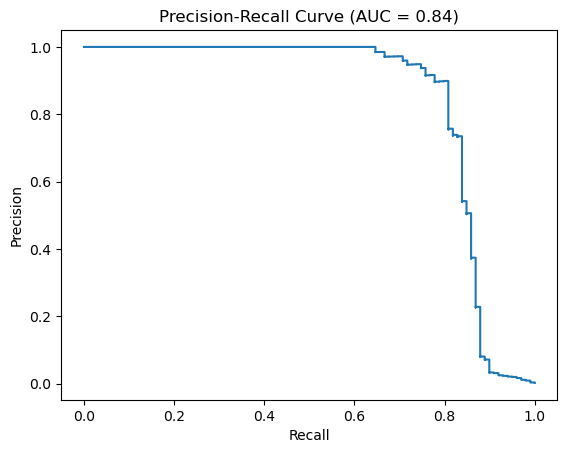

Area Under the Precision-Recall Curve (AUPRC): 0.84


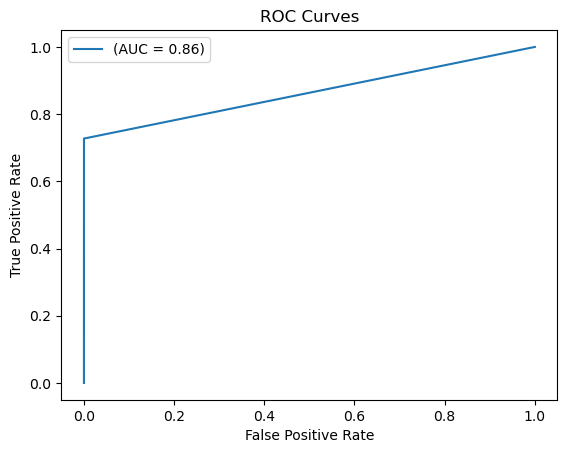

[[56887     4]
 [   27    72]]
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.95      0.73      0.82        99

    accuracy                           1.00     56990
   macro avg       0.97      0.86      0.91     56990
weighted avg       1.00      1.00      1.00     56990



,type,accuracy,Precision,Recall,F1 Score,auc,aucprc
0,original,0.999456,0.947368,0.727273,0.822857,0.863601,0.841697


In [26]:
res_df = add_res(res_df, 'original', X_train1, X_val, y_train, y_val)
res_df

### undersampling
even though doing under sampling on train dataset is not recommended since we will be left on 394*2 data points, we will still do it to see it's preformance on the validation dataset

In [28]:
y_train.value_counts()

Class
0    199020
1       344
Name: count, dtype: int64

In [29]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=2908)
X_under, y_under = rus.fit_resample(X_train, y_train)

In [30]:
y_under.value_counts()

Class
0    344
1    344
Name: count, dtype: int64

<Axes: >

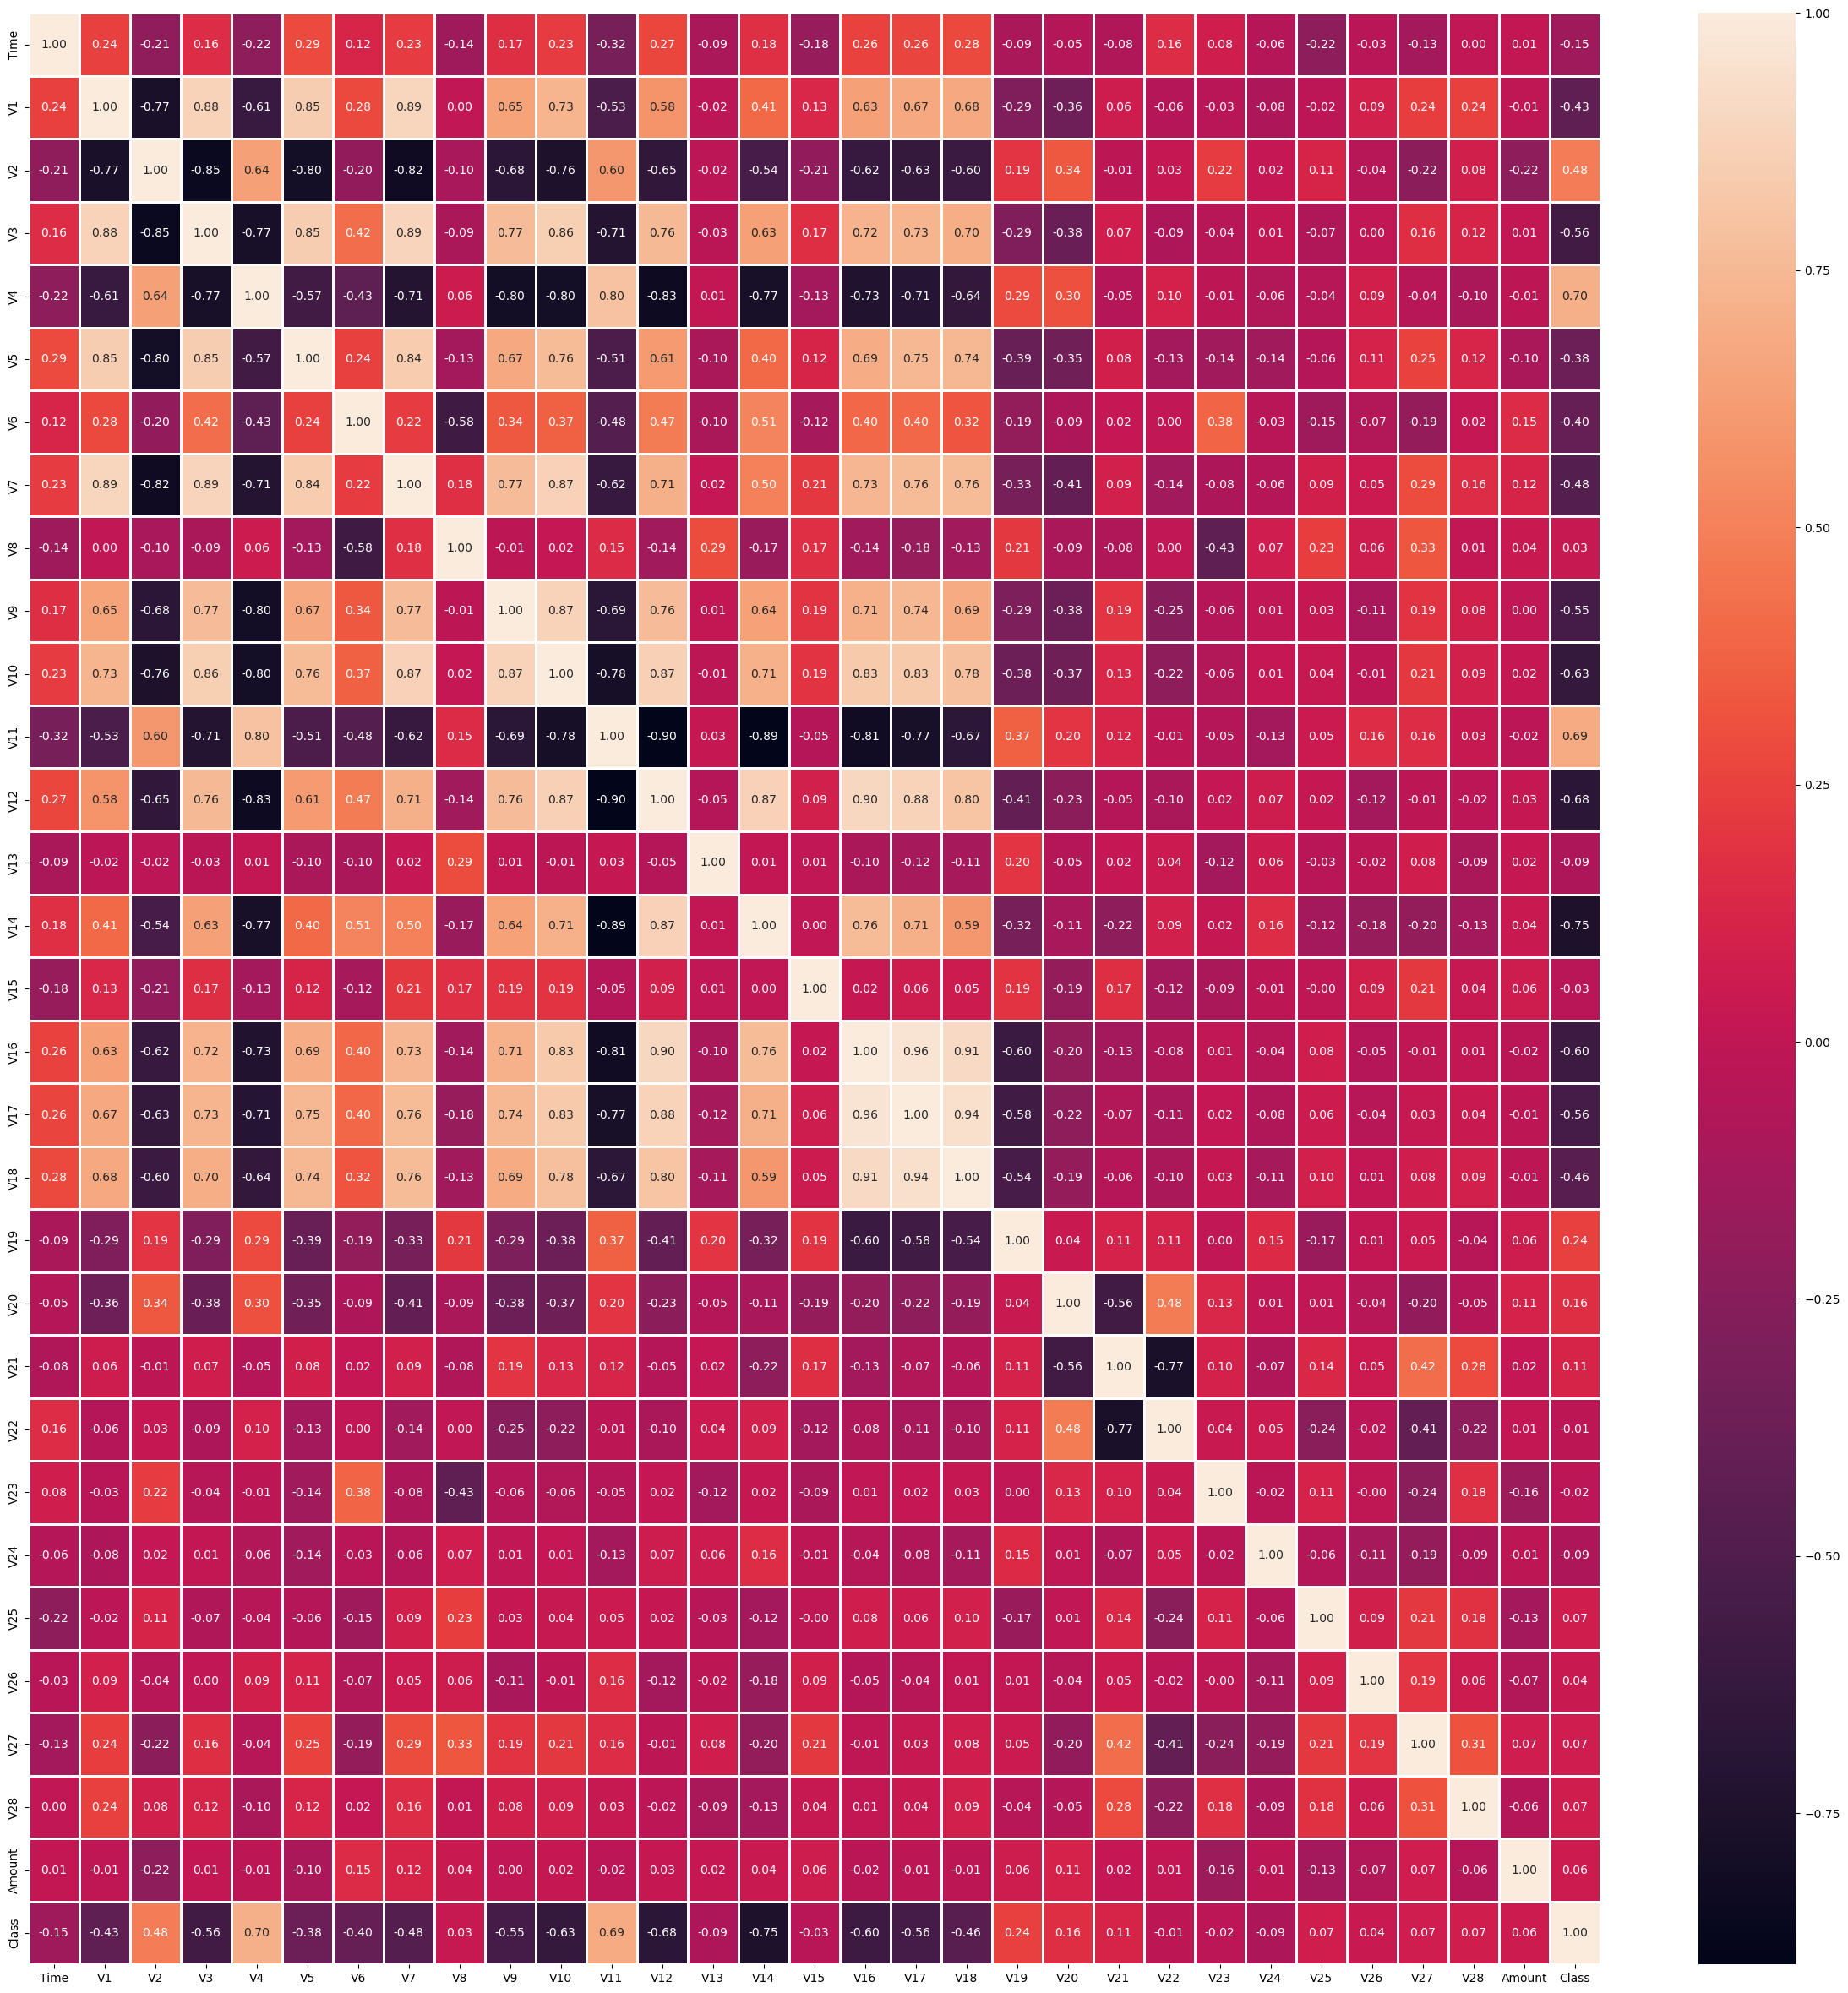

In [36]:
df_under = X_under.copy()
df_under['Class'] = y_under

plt.figure(figsize = (30,30))
sns.heatmap(df_under.corr(), linewidths= 1, annot=True, fmt='.2f')

In [37]:
X_val_under = X_val.copy()

In [38]:
X_under['Amount'] = scaler.fit_transform(X_under['Amount'].to_numpy().reshape(-1,1))
X_val_under['Amount'] = scaler.transform(X_val_under['Amount'].to_numpy().reshape(-1,1))

X_under['Time'] = scaler2.fit_transform(X_under['Time'].to_numpy().reshape(-1,1))
X_val_under['Time'] = scaler2.transform(X_val_under['Time'].to_numpy().reshape(-1,1))

[0]	validation_0-logloss:0.49468
[20]	validation_0-logloss:0.13723
[40]	validation_0-logloss:0.12930
[60]	validation_0-logloss:0.13024
[80]	validation_0-logloss:0.13145
[99]	validation_0-logloss:0.13179


<Figure size 800x600 with 0 Axes>

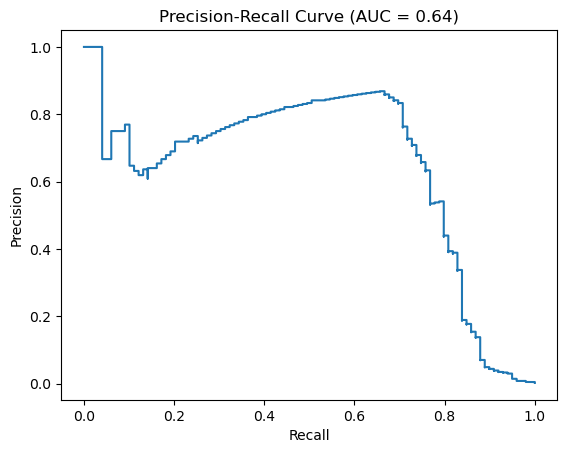

Area Under the Precision-Recall Curve (AUPRC): 0.64


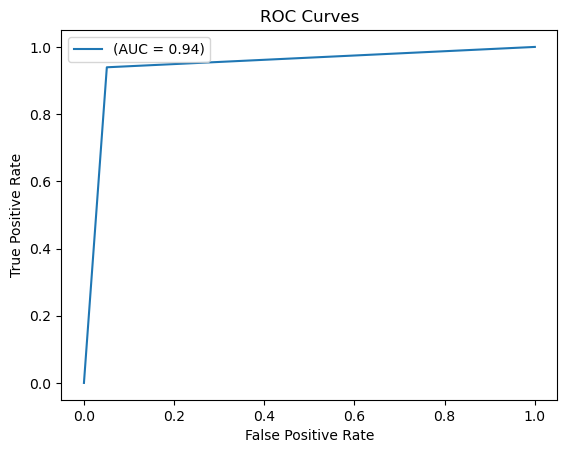

[[54004  2887]
 [    6    93]]
              precision    recall  f1-score   support

   not fraud       1.00      0.95      0.97     56891
       fraud       0.03      0.94      0.06        99

    accuracy                           0.95     56990
   macro avg       0.52      0.94      0.52     56990
weighted avg       1.00      0.95      0.97     56990



,type,accuracy,Precision,Recall,F1 Score,auc,aucprc
0,original,0.999456,0.947368,0.727273,0.822857,0.863601,0.841697
0,undersample,0.949237,0.031208,0.939394,0.060409,0.944324,0.642091


In [39]:
res_df = add_res(res_df, 'undersample', X_under, X_val_under, y_under, y_val)
res_df

### oversampling

In [40]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=2908)
X_over, y_over = ros.fit_resample(X_train, y_train)

In [41]:
y_over.value_counts()

Class
0    199020
1    199020
Name: count, dtype: int64

<Axes: >

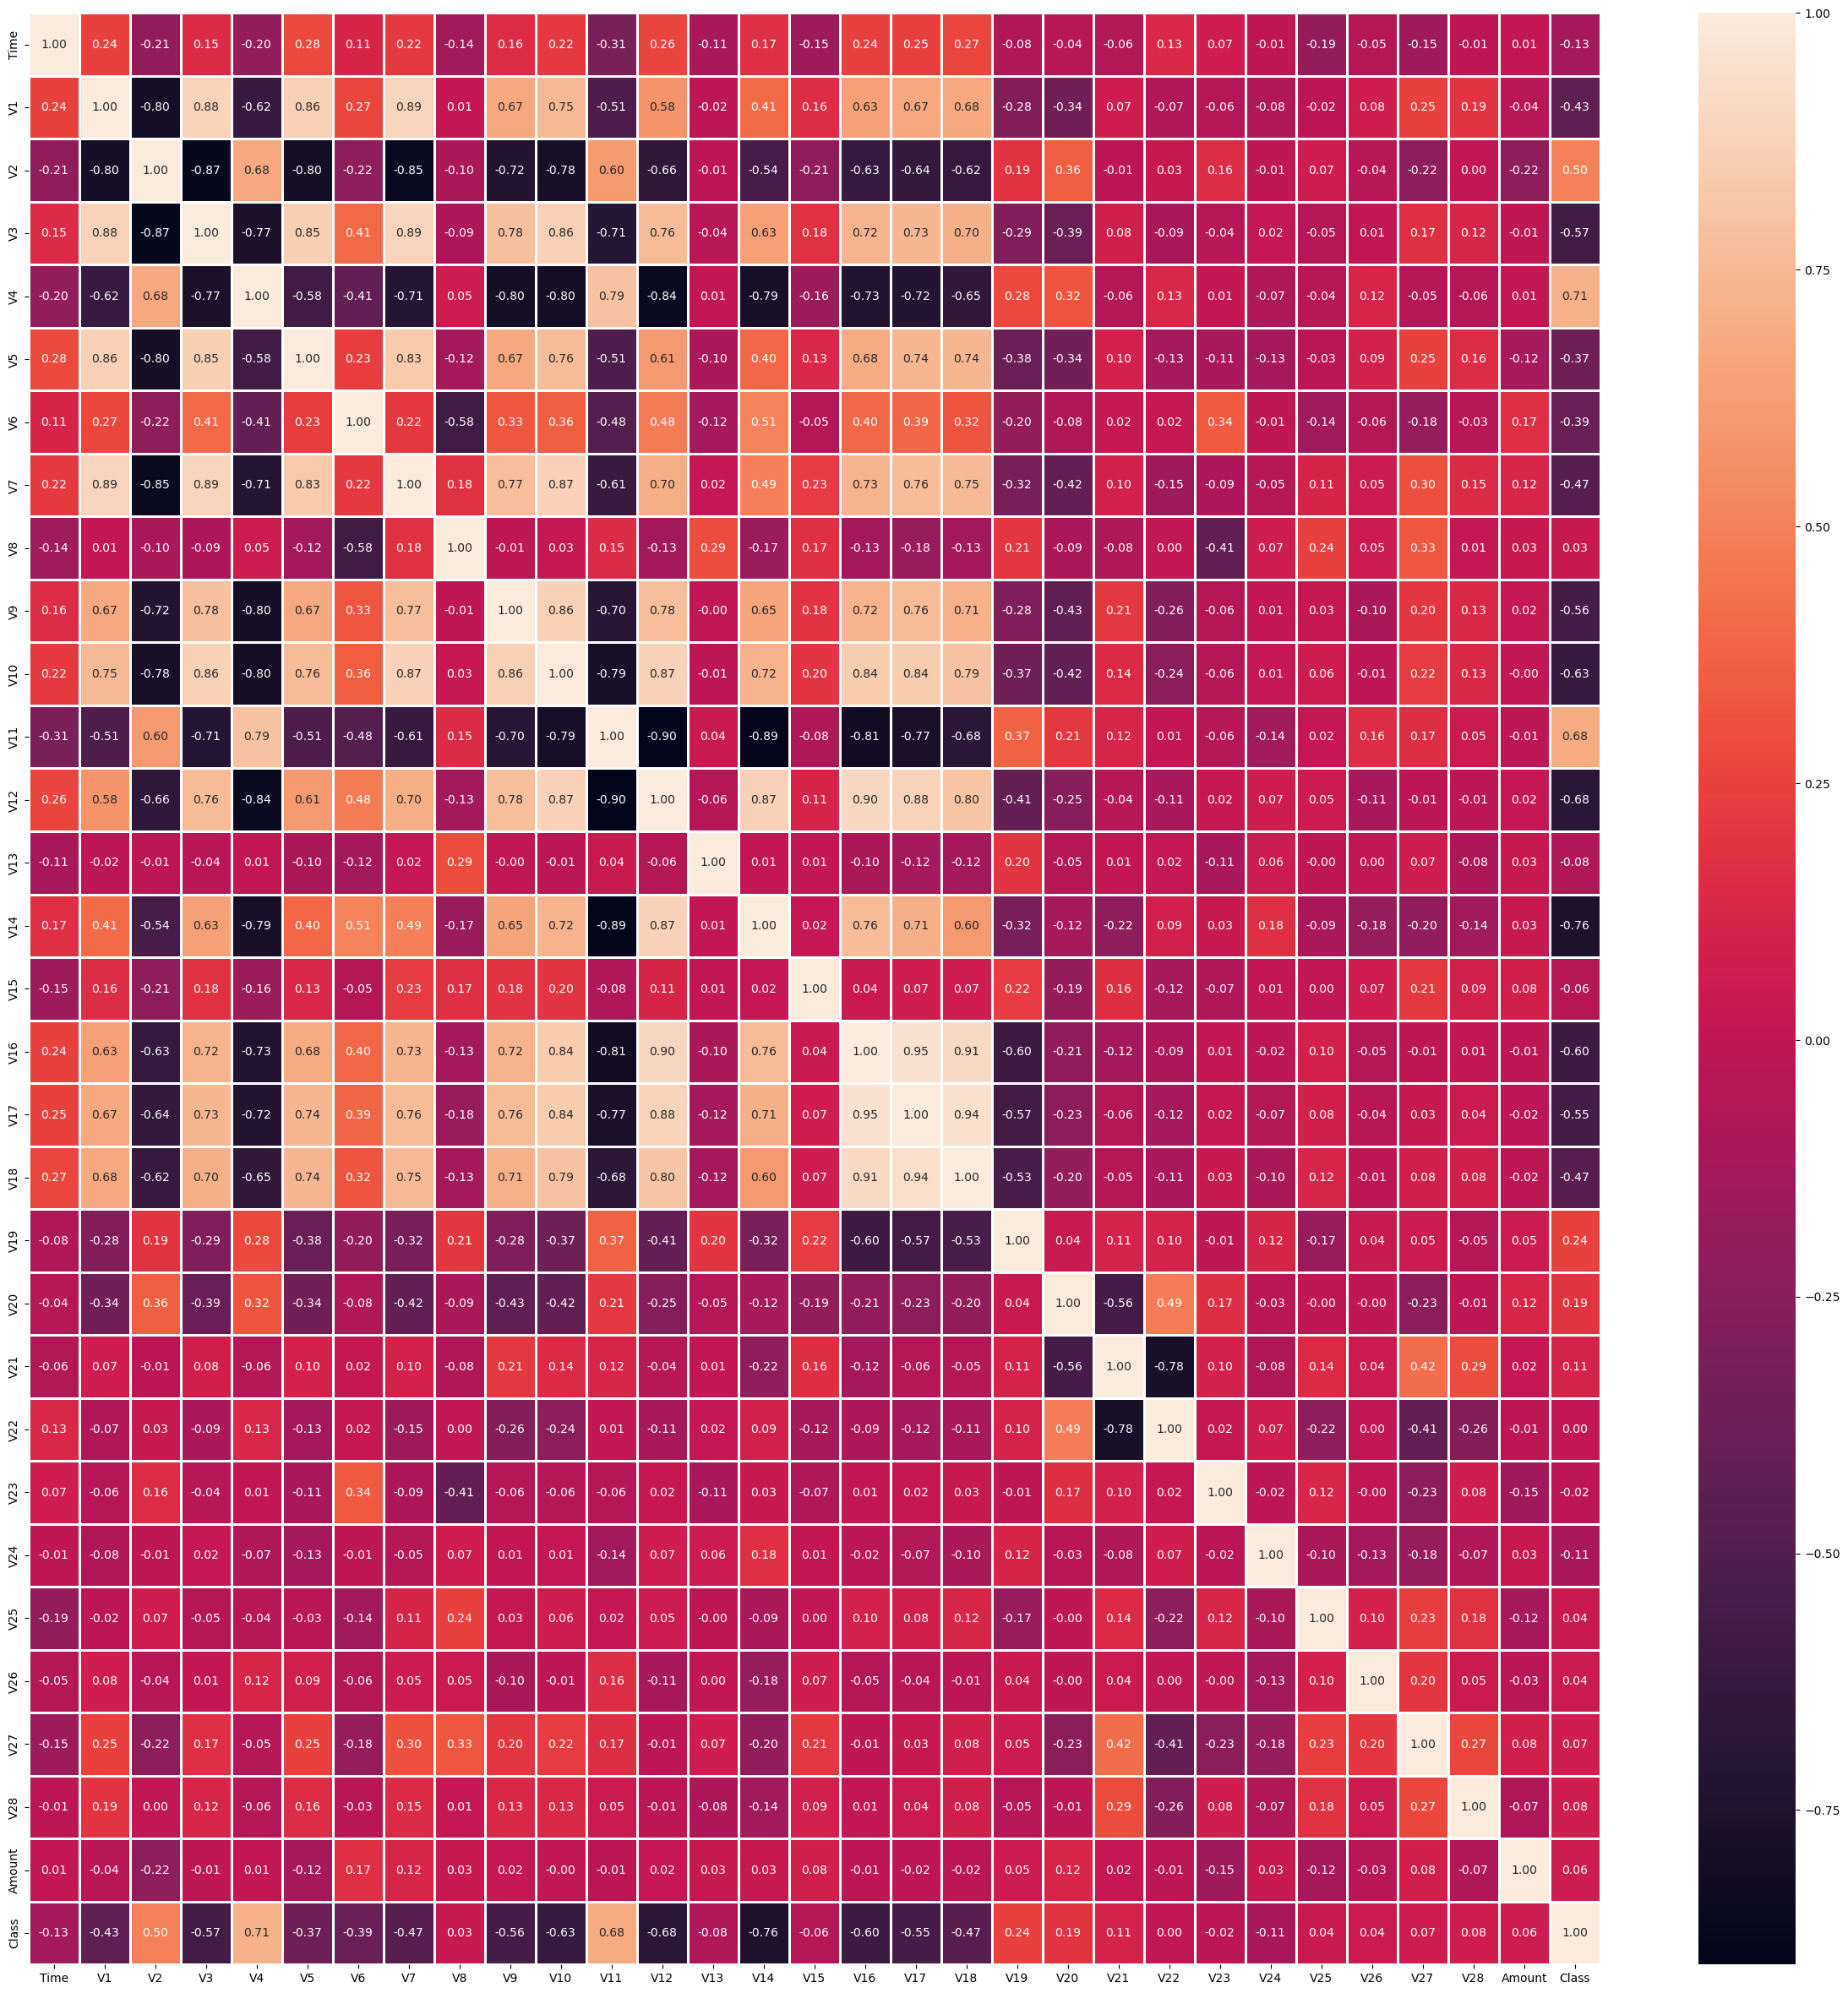

In [42]:
df_over = X_over.copy()
df_over['Class'] = y_over

plt.figure(figsize = (30,30))
sns.heatmap(df_over.corr(), linewidths= 1, annot=True, fmt='.2f')

In [43]:
X_val_over = X_val.copy()

In [44]:
X_over['Amount'] = scaler.fit_transform(X_over['Amount'].to_numpy().reshape(-1,1))
X_val_over['Amount'] = scaler.transform(X_val_over['Amount'].to_numpy().reshape(-1,1))

X_over['Time'] = scaler2.fit_transform(X_over['Time'].to_numpy().reshape(-1,1))
X_val_over['Time'] = scaler2.transform(X_val_over['Time'].to_numpy().reshape(-1,1))

[0]	validation_0-logloss:0.45834
[20]	validation_0-logloss:0.01050
[40]	validation_0-logloss:0.00356
[60]	validation_0-logloss:0.00326
[80]	validation_0-logloss:0.00339
[99]	validation_0-logloss:0.00349


<Figure size 800x600 with 0 Axes>

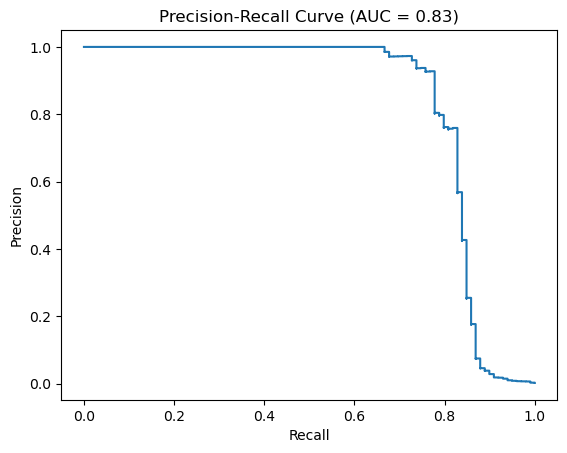

Area Under the Precision-Recall Curve (AUPRC): 0.83


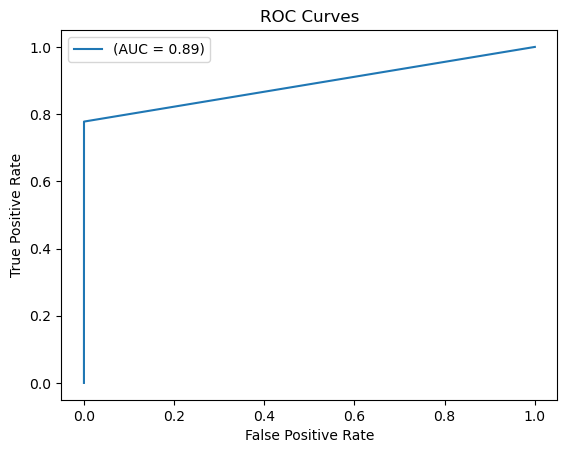

[[56884     7]
 [   22    77]]
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.92      0.78      0.84        99

    accuracy                           1.00     56990
   macro avg       0.96      0.89      0.92     56990
weighted avg       1.00      1.00      1.00     56990



,type,accuracy,Precision,Recall,F1 Score,auc,aucprc
0,original,0.999456,0.947368,0.727273,0.822857,0.863601,0.841697
0,undersample,0.949237,0.031208,0.939394,0.060409,0.944324,0.642091
0,oversample,0.999491,0.916667,0.777778,0.841530,0.888827,0.829314


In [45]:
res_df = add_res(res_df, 'oversample', X_over, X_val_over, y_over, y_val)
res_df

### oversampling using smote

In [46]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2908)
X_smt, y_smt = sm.fit_resample(X_train, y_train)

In [47]:
y_smt.value_counts()

Class
0    199020
1    199020
Name: count, dtype: int64

In [48]:
X_val_smt = X_val.copy()

In [49]:
X_smt['Amount'] = scaler.fit_transform(X_smt['Amount'].to_numpy().reshape(-1,1))
X_val_smt['Amount'] = scaler.transform(X_val_smt['Amount'].to_numpy().reshape(-1,1))

X_smt['Time'] = scaler2.fit_transform(X_smt['Time'].to_numpy().reshape(-1,1))
X_val_smt['Time'] = scaler2.transform(X_val_smt['Time'].to_numpy().reshape(-1,1))

[0]	validation_0-logloss:0.45337
[20]	validation_0-logloss:0.01339
[40]	validation_0-logloss:0.00413
[60]	validation_0-logloss:0.00335
[80]	validation_0-logloss:0.00342
[99]	validation_0-logloss:0.00350


<Figure size 800x600 with 0 Axes>

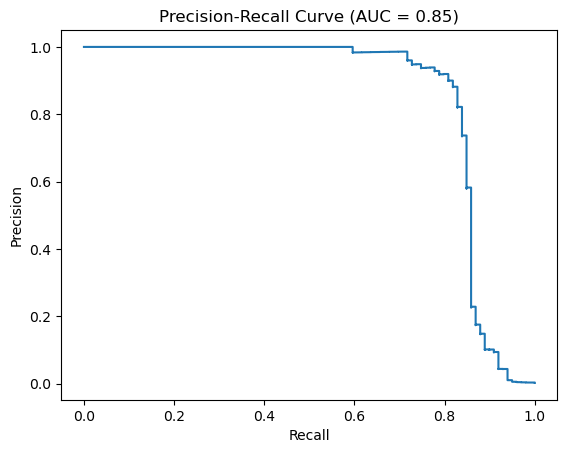

Area Under the Precision-Recall Curve (AUPRC): 0.85


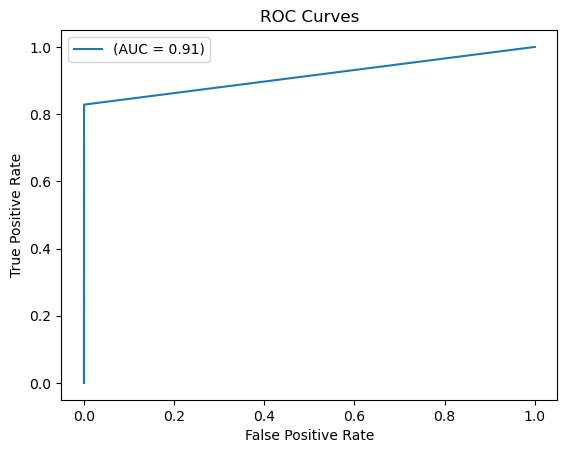

[[56879    12]
 [   17    82]]
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.87      0.83      0.85        99

    accuracy                           1.00     56990
   macro avg       0.94      0.91      0.92     56990
weighted avg       1.00      1.00      1.00     56990



,type,accuracy,Precision,Recall,F1 Score,auc,aucprc
0,original,0.999456,0.947368,0.727273,0.822857,0.863601,0.841697
0,undersample,0.949237,0.031208,0.939394,0.060409,0.944324,0.642091
0,oversample,0.999491,0.916667,0.777778,0.841530,0.888827,0.829314
0,smote,0.999491,0.872340,0.828283,0.849741,0.914036,0.849772


In [50]:
res_df = add_res(res_df, 'smote', X_smt, X_val_smt, y_smt, y_val)
res_df

### smotenn
combination of under and over sampling using smotenn. the advantage is smotenn generates less noisy samples compare to smote since smote is interpolating new points betweet marginal outliers and inliers

In [51]:
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=2908)
X_smtnn, y_smtnn = smote_enn.fit_resample(X_train, y_train)

In [52]:
y_train.value_counts()

Class
0    199020
1       344
Name: count, dtype: int64

In [53]:
y_smtnn.value_counts()

Class
1    191303
0    183732
Name: count, dtype: int64

In [54]:
X_val_smtnn = X_val.copy()

In [55]:
X_smtnn['Amount'] = scaler.fit_transform(X_smtnn['Amount'].to_numpy().reshape(-1,1))
X_val_smtnn['Amount'] = scaler.transform(X_val_smtnn['Amount'].to_numpy().reshape(-1,1))

X_smtnn['Time'] = scaler2.fit_transform(X_smtnn['Time'].to_numpy().reshape(-1,1))
X_val_smtnn['Time'] = scaler2.transform(X_val_smtnn['Time'].to_numpy().reshape(-1,1))

[0]	validation_0-logloss:0.46257
[20]	validation_0-logloss:0.01243
[40]	validation_0-logloss:0.00414
[60]	validation_0-logloss:0.00344
[80]	validation_0-logloss:0.00346
[99]	validation_0-logloss:0.00359


<Figure size 800x600 with 0 Axes>

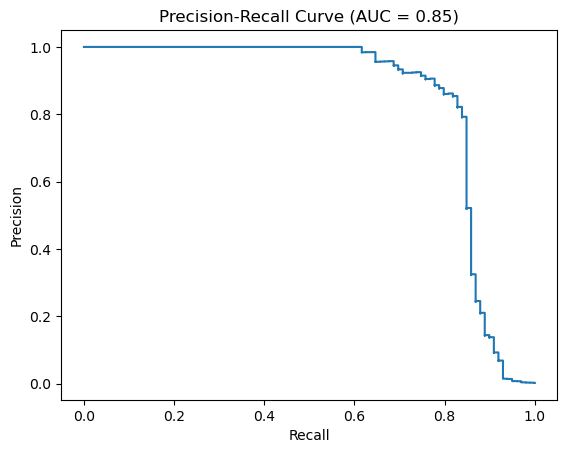

Area Under the Precision-Recall Curve (AUPRC): 0.85


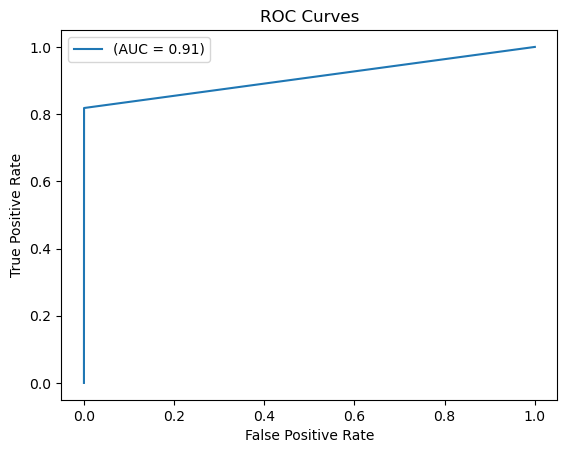

[[56878    13]
 [   18    81]]
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.86      0.82      0.84        99

    accuracy                           1.00     56990
   macro avg       0.93      0.91      0.92     56990
weighted avg       1.00      1.00      1.00     56990



,type,accuracy,Precision,Recall,F1 Score,auc,aucprc
0,original,0.999456,0.947368,0.727273,0.822857,0.863601,0.841697
0,undersample,0.949237,0.031208,0.939394,0.060409,0.944324,0.642091
0,oversample,0.999491,0.916667,0.777778,0.841530,0.888827,0.829314
0,smote,0.999491,0.872340,0.828283,0.849741,0.914036,0.849772
0,smotenn,0.999456,0.861702,0.818182,0.839378,0.908977,0.846537


In [56]:
res_df = add_res(res_df, 'smotenn', X_smtnn, X_val_smtnn, y_smtnn, y_val)
res_df

### smote with unbalance proportion

In [83]:
from collections import Counter
counts = Counter(y_train)
majority_class = max(counts, key=counts.get)
minority_class = min(counts, key=counts.get)

In [84]:
y_train.value_counts(normalize=True)

Class
0    0.998275
1    0.001725
Name: proportion, dtype: float64

0.1
[0]	validation_0-logloss:0.13098
[20]	validation_0-logloss:0.00483
[40]	validation_0-logloss:0.00313
[60]	validation_0-logloss:0.00307
[80]	validation_0-logloss:0.00328
[99]	validation_0-logloss:0.00340


<Figure size 800x600 with 0 Axes>

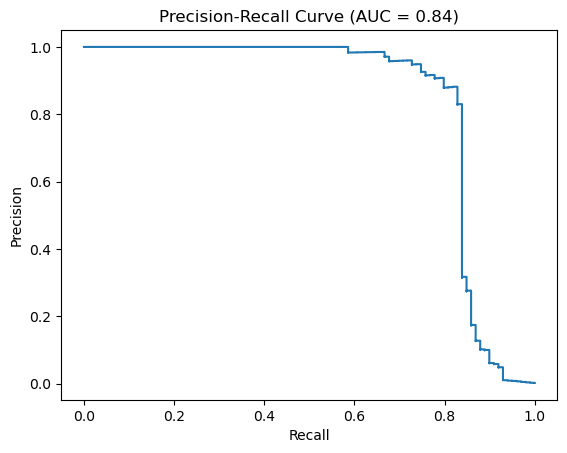

Area Under the Precision-Recall Curve (AUPRC): 0.84


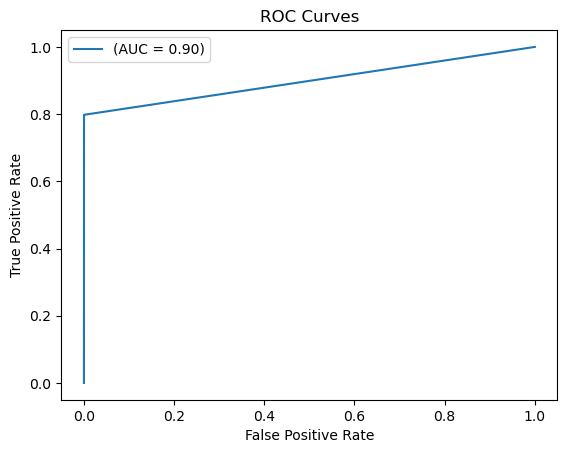

[[56881    10]
 [   20    79]]
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.89      0.80      0.84        99

    accuracy                           1.00     56990
   macro avg       0.94      0.90      0.92     56990
weighted avg       1.00      1.00      1.00     56990

0.2
[0]	validation_0-logloss:0.17105
[20]	validation_0-logloss:0.00607
[40]	validation_0-logloss:0.00304
[60]	validation_0-logloss:0.00289
[80]	validation_0-logloss:0.00302
[99]	validation_0-logloss:0.00313


<Figure size 800x600 with 0 Axes>

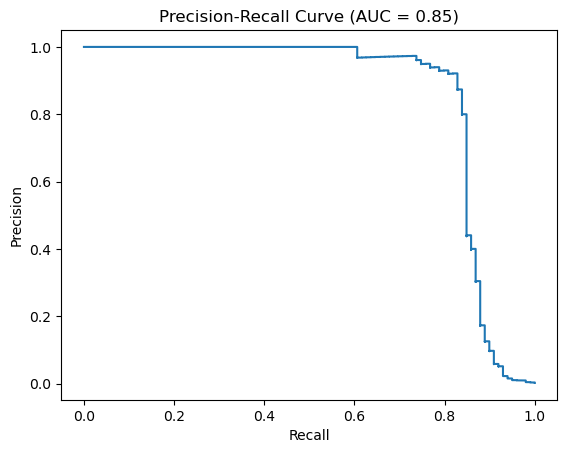

Area Under the Precision-Recall Curve (AUPRC): 0.85


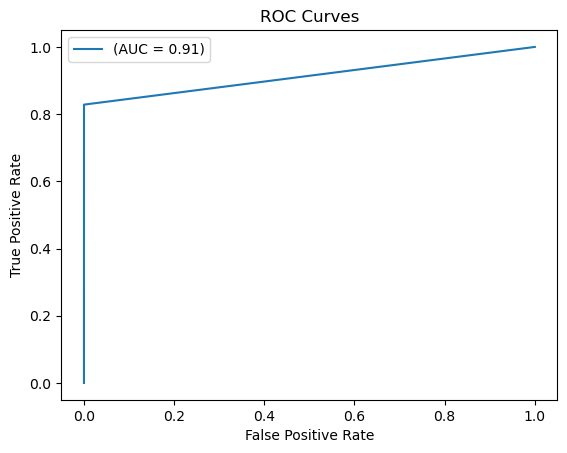

[[56882     9]
 [   17    82]]
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.90      0.83      0.86        99

    accuracy                           1.00     56990
   macro avg       0.95      0.91      0.93     56990
weighted avg       1.00      1.00      1.00     56990

0.30000000000000004
[0]	validation_0-logloss:0.21182
[20]	validation_0-logloss:0.00778
[40]	validation_0-logloss:0.00333
[60]	validation_0-logloss:0.00295
[80]	validation_0-logloss:0.00308
[99]	validation_0-logloss:0.00316


<Figure size 800x600 with 0 Axes>

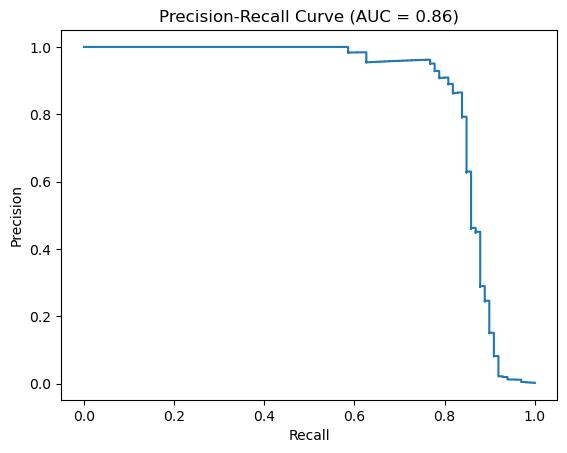

Area Under the Precision-Recall Curve (AUPRC): 0.86


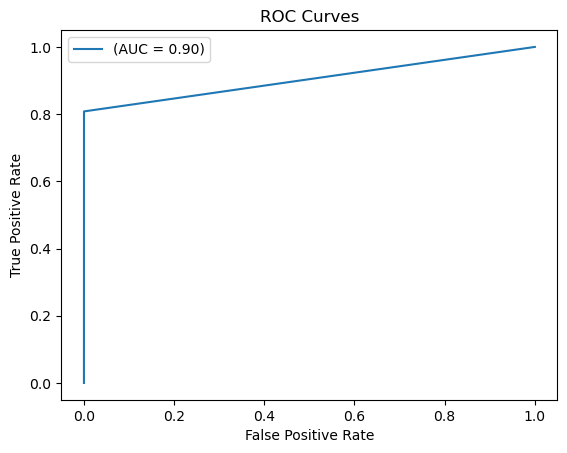

[[56883     8]
 [   19    80]]
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.91      0.81      0.86        99

    accuracy                           1.00     56990
   macro avg       0.95      0.90      0.93     56990
weighted avg       1.00      1.00      1.00     56990

0.4
[0]	validation_0-logloss:0.25213
[20]	validation_0-logloss:0.00838
[40]	validation_0-logloss:0.00350
[60]	validation_0-logloss:0.00313
[80]	validation_0-logloss:0.00325
[99]	validation_0-logloss:0.00336


<Figure size 800x600 with 0 Axes>

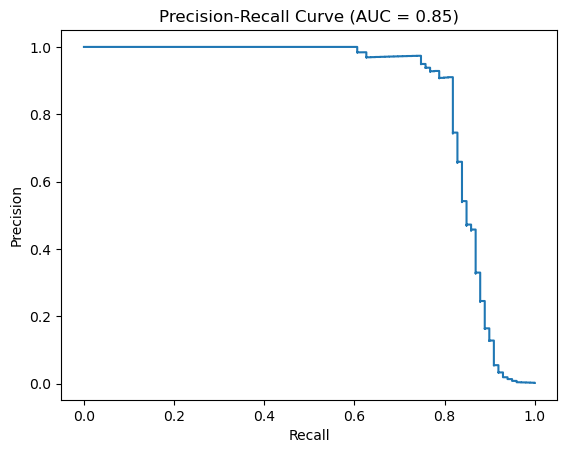

Area Under the Precision-Recall Curve (AUPRC): 0.85


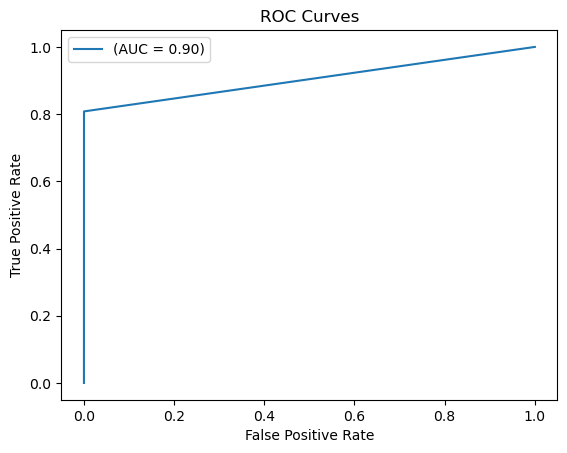

[[56883     8]
 [   19    80]]
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.91      0.81      0.86        99

    accuracy                           1.00     56990
   macro avg       0.95      0.90      0.93     56990
weighted avg       1.00      1.00      1.00     56990

0.5
[0]	validation_0-logloss:0.29163
[20]	validation_0-logloss:0.00957
[40]	validation_0-logloss:0.00372
[60]	validation_0-logloss:0.00327
[80]	validation_0-logloss:0.00338
[99]	validation_0-logloss:0.00345


<Figure size 800x600 with 0 Axes>

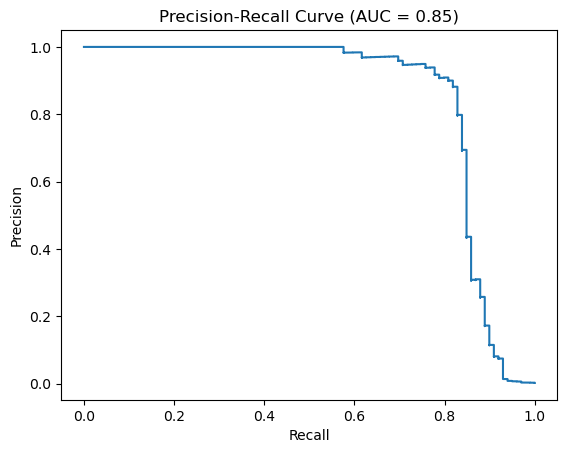

Area Under the Precision-Recall Curve (AUPRC): 0.85


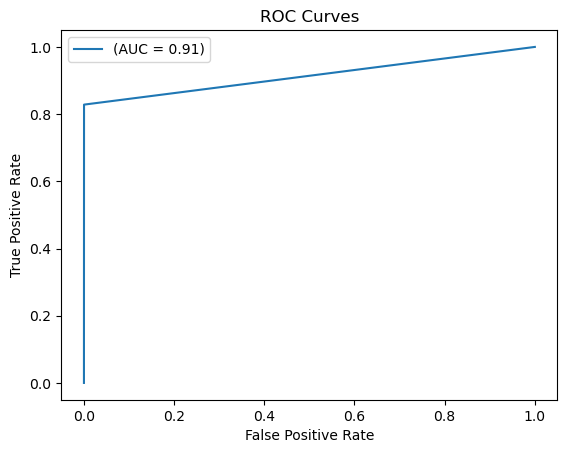

[[56880    11]
 [   17    82]]
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.88      0.83      0.85        99

    accuracy                           1.00     56990
   macro avg       0.94      0.91      0.93     56990
weighted avg       1.00      1.00      1.00     56990

0.6
[0]	validation_0-logloss:0.32931
[20]	validation_0-logloss:0.01047
[40]	validation_0-logloss:0.00359
[60]	validation_0-logloss:0.00303
[80]	validation_0-logloss:0.00313
[99]	validation_0-logloss:0.00326


<Figure size 800x600 with 0 Axes>

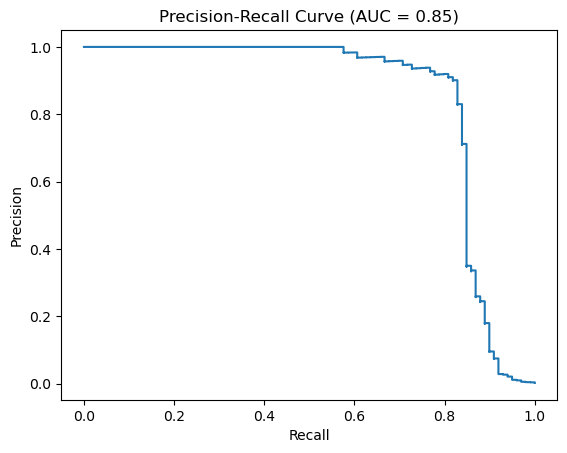

Area Under the Precision-Recall Curve (AUPRC): 0.85


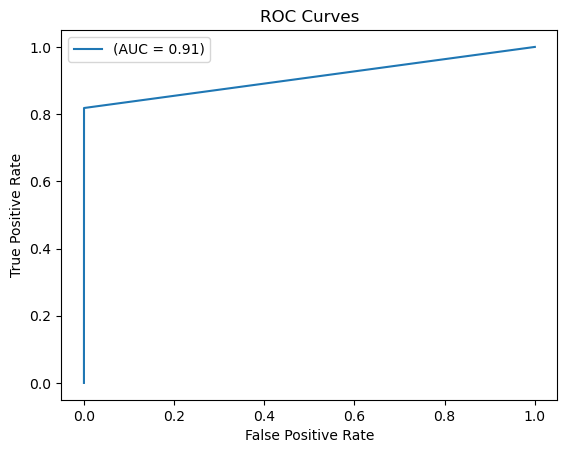

[[56882     9]
 [   18    81]]
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.90      0.82      0.86        99

    accuracy                           1.00     56990
   macro avg       0.95      0.91      0.93     56990
weighted avg       1.00      1.00      1.00     56990

0.7000000000000001
[0]	validation_0-logloss:0.36304
[20]	validation_0-logloss:0.01133
[40]	validation_0-logloss:0.00441
[60]	validation_0-logloss:0.00344
[80]	validation_0-logloss:0.00349
[99]	validation_0-logloss:0.00358


<Figure size 800x600 with 0 Axes>

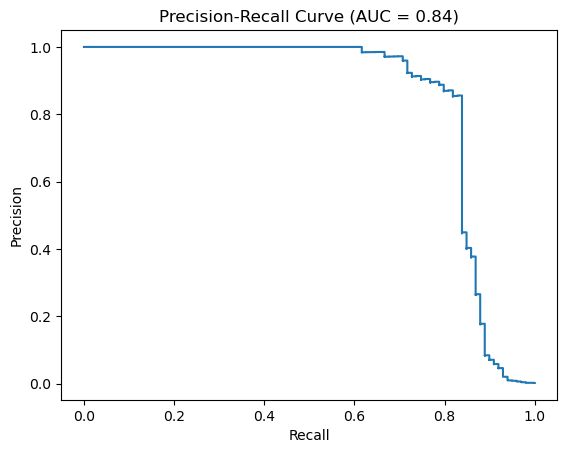

Area Under the Precision-Recall Curve (AUPRC): 0.84


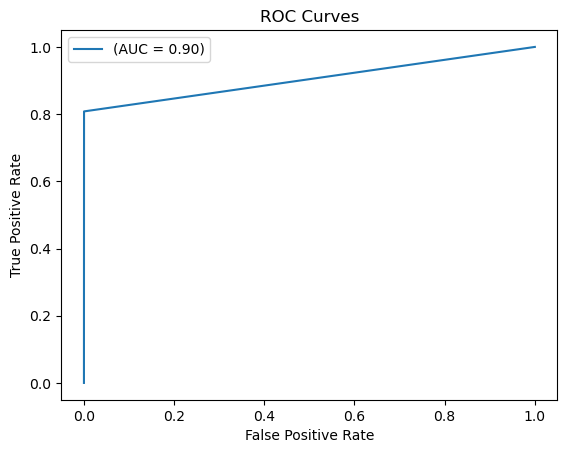

[[56879    12]
 [   19    80]]
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.87      0.81      0.84        99

    accuracy                           1.00     56990
   macro avg       0.93      0.90      0.92     56990
weighted avg       1.00      1.00      1.00     56990

0.8
[0]	validation_0-logloss:0.39547
[20]	validation_0-logloss:0.01206
[40]	validation_0-logloss:0.00400
[60]	validation_0-logloss:0.00322
[80]	validation_0-logloss:0.00327
[99]	validation_0-logloss:0.00339


<Figure size 800x600 with 0 Axes>

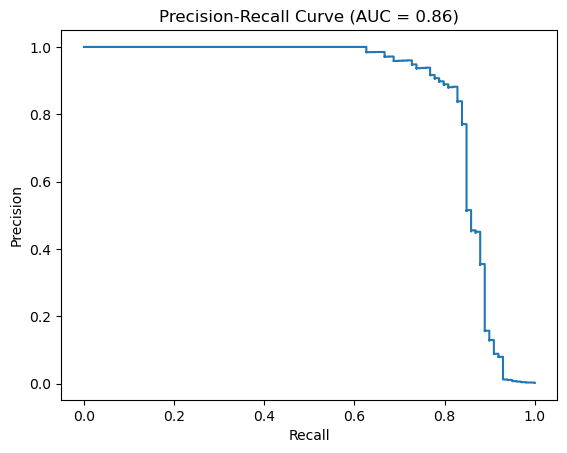

Area Under the Precision-Recall Curve (AUPRC): 0.86


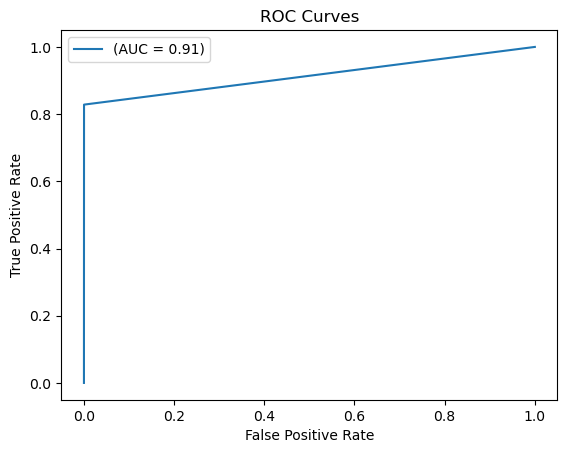

[[56880    11]
 [   17    82]]
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.88      0.83      0.85        99

    accuracy                           1.00     56990
   macro avg       0.94      0.91      0.93     56990
weighted avg       1.00      1.00      1.00     56990

0.9
[0]	validation_0-logloss:0.42602
[20]	validation_0-logloss:0.01234
[40]	validation_0-logloss:0.00413
[60]	validation_0-logloss:0.00329
[80]	validation_0-logloss:0.00331
[99]	validation_0-logloss:0.00346


<Figure size 800x600 with 0 Axes>

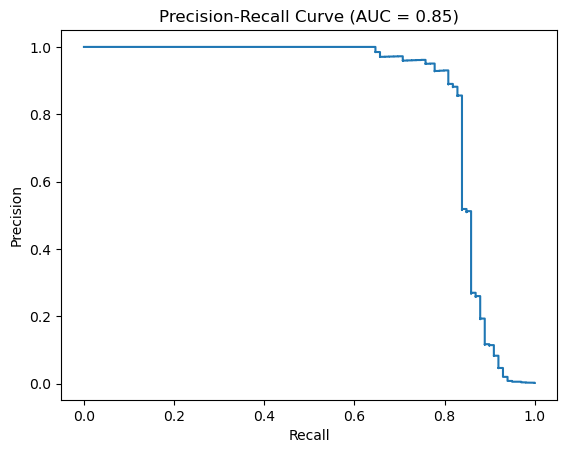

Area Under the Precision-Recall Curve (AUPRC): 0.85


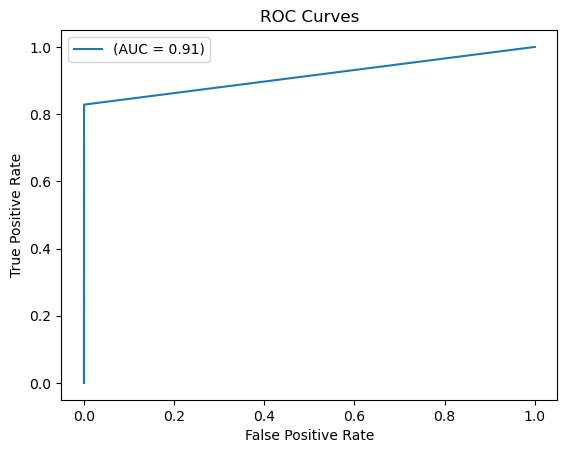

[[56879    12]
 [   17    82]]
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.87      0.83      0.85        99

    accuracy                           1.00     56990
   macro avg       0.94      0.91      0.92     56990
weighted avg       1.00      1.00      1.00     56990



In [85]:
dummy_df = pd.DataFrame()
for i in range(0, 9):
    print(0.1 + 0.1*i)
    desired_ratio = 0.1 + 0.1*i
    target_minority_count = int(counts[majority_class] * desired_ratio)
    sampling_strategy = {minority_class: target_minority_count}
    sm2 = SMOTE(sampling_strategy= sampling_strategy, random_state=2908)
    X_smt2, y_smt2 = sm2.fit_resample(X_train, y_train)

    X_val_smt2 = X_val.copy()

    X_smt2['Amount'] = scaler.fit_transform(X_smt2['Amount'].to_numpy().reshape(-1,1))
    X_val_smt2['Amount'] = scaler.transform(X_val_smt2['Amount'].to_numpy().reshape(-1,1))

    X_smt2['Time'] = scaler2.fit_transform(X_smt2['Time'].to_numpy().reshape(-1,1))
    X_val_smt2['Time'] = scaler2.transform(X_val_smt2['Time'].to_numpy().reshape(-1,1))

    dummy_df = add_res(dummy_df, round(desired_ratio, 2), X_smt2, X_val_smt2, y_smt2, y_val)

Text(0, 0.5, 'value')

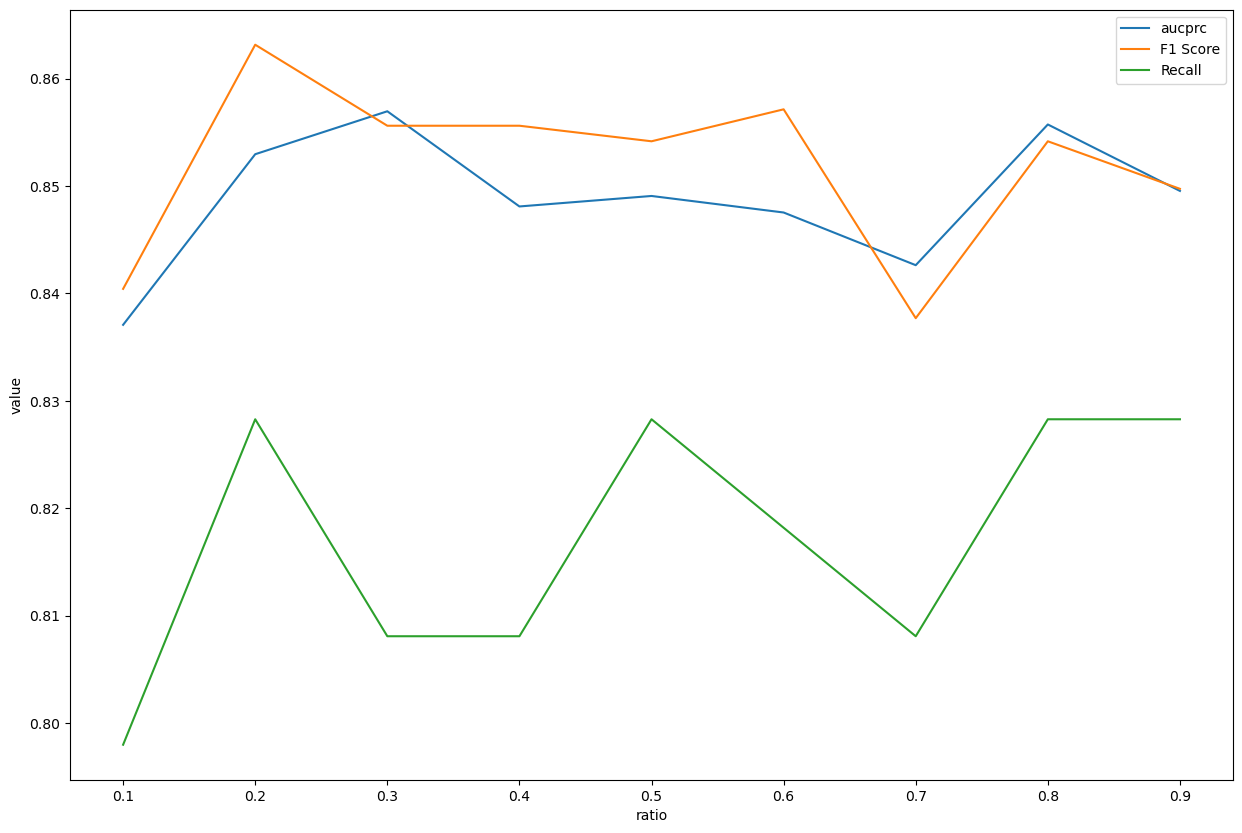

In [87]:
plt.figure(figsize= (15,10))
sns.lineplot(data= dummy_df, x = 'type', y = 'aucprc', label= 'aucprc')
sns.lineplot(data= dummy_df, x = 'type', y = 'F1 Score', label = 'F1 Score')
sns.lineplot(data= dummy_df, x = 'type', y = 'Recall', label = 'Recall')
plt.xlabel('ratio')
plt.ylabel('value')

best ratio is 0.2 between majority and minority

[0]	validation_0-logloss:0.17105
[20]	validation_0-logloss:0.00607
[40]	validation_0-logloss:0.00304
[60]	validation_0-logloss:0.00289
[80]	validation_0-logloss:0.00302
[99]	validation_0-logloss:0.00313


<Figure size 800x600 with 0 Axes>

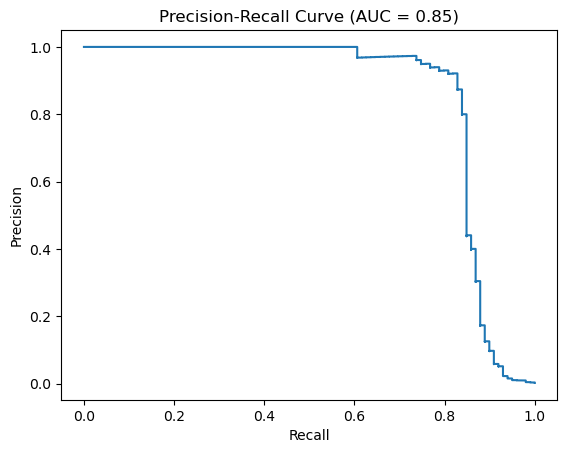

Area Under the Precision-Recall Curve (AUPRC): 0.85


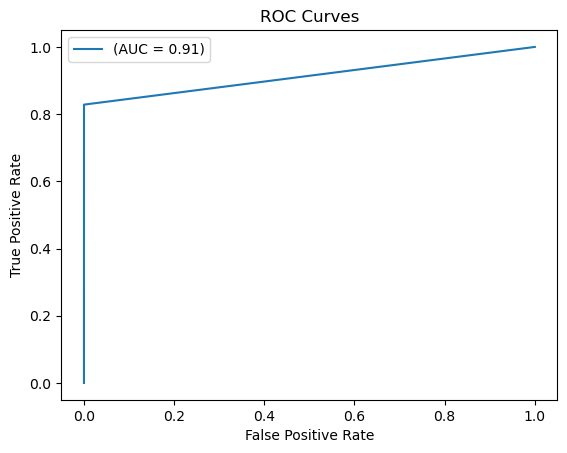

[[56882     9]
 [   17    82]]
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.90      0.83      0.86        99

    accuracy                           1.00     56990
   macro avg       0.95      0.91      0.93     56990
weighted avg       1.00      1.00      1.00     56990



,type,accuracy,Precision,Recall,F1 Score,auc,aucprc
0,original,0.999456,0.947368,0.727273,0.822857,0.863601,0.841697
0,undersample,0.949237,0.031208,0.939394,0.060409,0.944324,0.642091
0,oversample,0.999491,0.916667,0.777778,0.841530,0.888827,0.829314
0,smote,0.999491,0.872340,0.828283,0.849741,0.914036,0.849772
0,smotenn,0.999456,0.861702,0.818182,0.839378,0.908977,0.846537
0,smote_imb,0.999509,0.881720,0.828283,0.854167,0.914045,0.849075
0,smote_imb,0.999544,0.901099,0.828283,0.863158,0.914062,0.852963


In [88]:
desired_ratio = 0.2

target_minority_count = int(counts[majority_class] * desired_ratio)
sampling_strategy = {minority_class: target_minority_count}

sm2 = SMOTE(sampling_strategy= sampling_strategy, random_state=2908)

X_smt2, y_smt2 = sm2.fit_resample(X_train, y_train)
y_smt2.value_counts()
X_val_smt2 = X_val.copy()
X_smt2['Amount'] = scaler.fit_transform(X_smt2['Amount'].to_numpy().reshape(-1,1))
X_val_smt2['Amount'] = scaler.transform(X_val_smt2['Amount'].to_numpy().reshape(-1,1))

X_smt2['Time'] = scaler2.fit_transform(X_smt2['Time'].to_numpy().reshape(-1,1))
X_val_smt2['Time'] = scaler2.transform(X_val_smt2['Time'].to_numpy().reshape(-1,1))
res_df = add_res(res_df, 'smote_imb', X_smt2, X_val_smt2, y_smt2, y_val)
res_df

### smotenn with unbalance proportion

0.1
[0]	validation_0-logloss:0.11851
[20]	validation_0-logloss:0.00359
[40]	validation_0-logloss:0.00308
[60]	validation_0-logloss:0.00326
[80]	validation_0-logloss:0.00344
[99]	validation_0-logloss:0.00359


<Figure size 800x600 with 0 Axes>

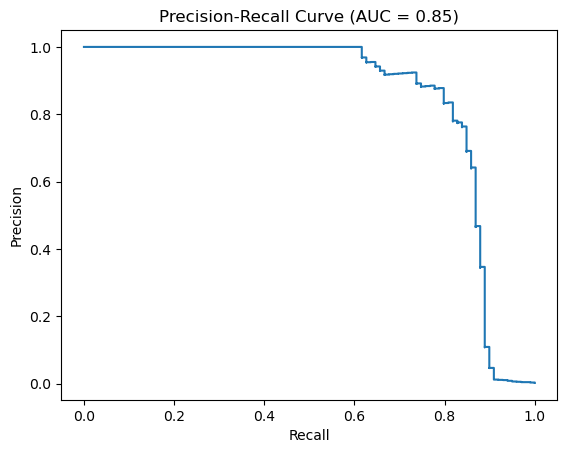

Area Under the Precision-Recall Curve (AUPRC): 0.85


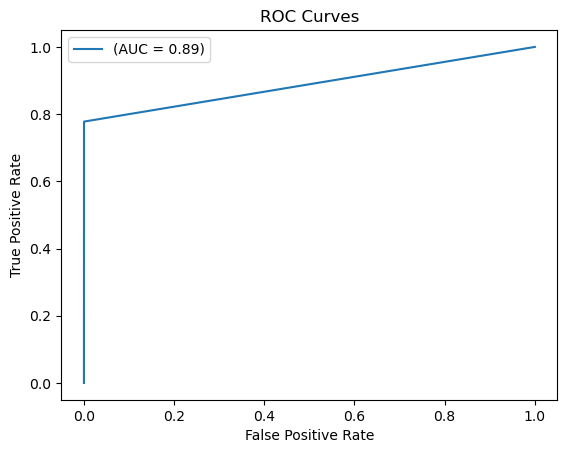

[[56881    10]
 [   22    77]]
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.89      0.78      0.83        99

    accuracy                           1.00     56990
   macro avg       0.94      0.89      0.91     56990
weighted avg       1.00      1.00      1.00     56990

0.2
[0]	validation_0-logloss:0.15628
[20]	validation_0-logloss:0.00480
[40]	validation_0-logloss:0.00324
[60]	validation_0-logloss:0.00329
[80]	validation_0-logloss:0.00338
[99]	validation_0-logloss:0.00346


<Figure size 800x600 with 0 Axes>

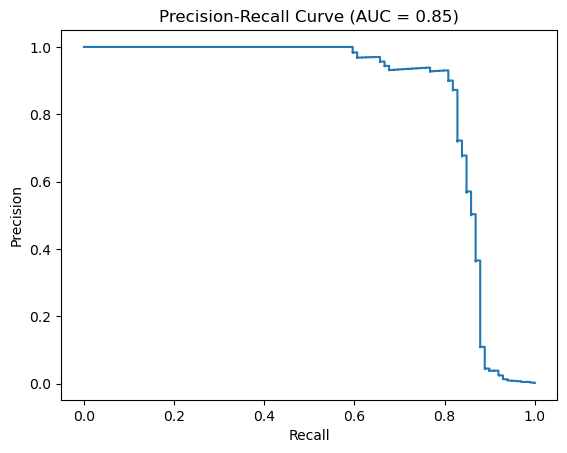

Area Under the Precision-Recall Curve (AUPRC): 0.85


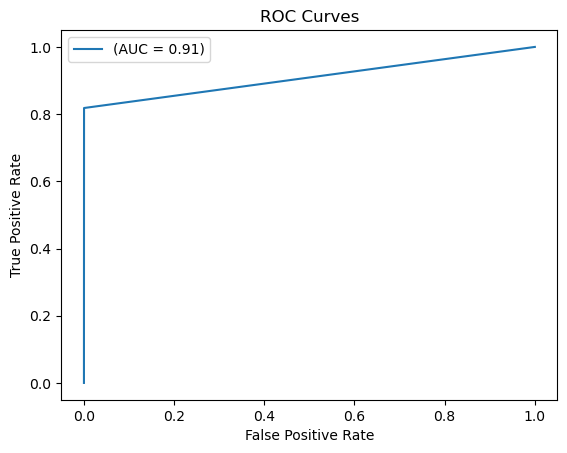

[[56879    12]
 [   18    81]]
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.87      0.82      0.84        99

    accuracy                           1.00     56990
   macro avg       0.94      0.91      0.92     56990
weighted avg       1.00      1.00      1.00     56990

0.30000000000000004
[0]	validation_0-logloss:0.19832
[20]	validation_0-logloss:0.00614
[40]	validation_0-logloss:0.00334
[60]	validation_0-logloss:0.00320
[80]	validation_0-logloss:0.00330
[99]	validation_0-logloss:0.00345


<Figure size 800x600 with 0 Axes>

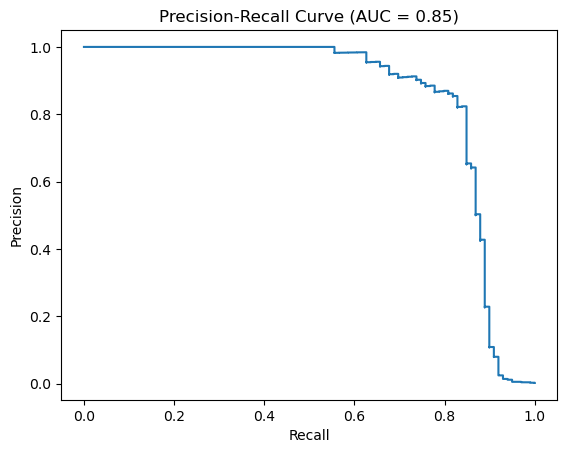

Area Under the Precision-Recall Curve (AUPRC): 0.85


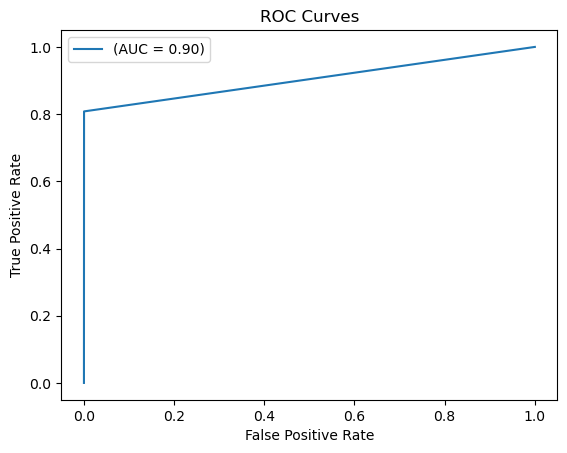

[[56878    13]
 [   19    80]]
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.86      0.81      0.83        99

    accuracy                           1.00     56990
   macro avg       0.93      0.90      0.92     56990
weighted avg       1.00      1.00      1.00     56990

0.4
[0]	validation_0-logloss:0.24200
[20]	validation_0-logloss:0.00725
[40]	validation_0-logloss:0.00364
[60]	validation_0-logloss:0.00343
[80]	validation_0-logloss:0.00357
[99]	validation_0-logloss:0.00365


<Figure size 800x600 with 0 Axes>

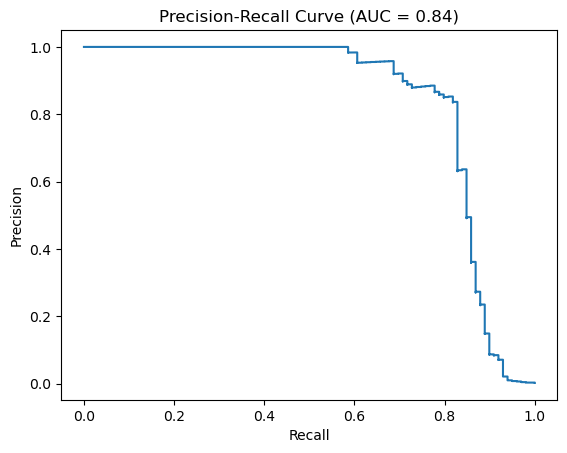

Area Under the Precision-Recall Curve (AUPRC): 0.84


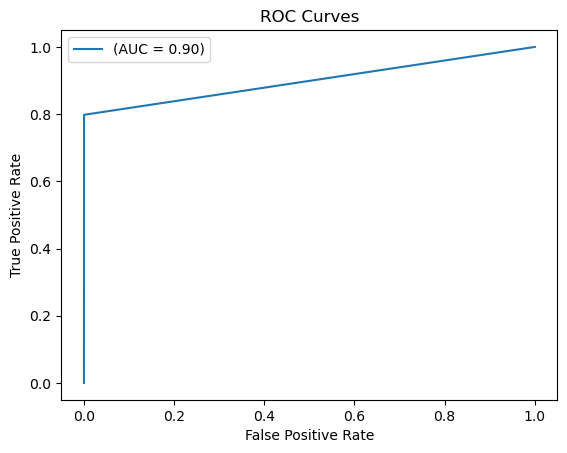

[[56877    14]
 [   20    79]]
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.85      0.80      0.82        99

    accuracy                           1.00     56990
   macro avg       0.92      0.90      0.91     56990
weighted avg       1.00      1.00      1.00     56990

0.5
[0]	validation_0-logloss:0.28540
[20]	validation_0-logloss:0.00948
[40]	validation_0-logloss:0.00348
[60]	validation_0-logloss:0.00312
[80]	validation_0-logloss:0.00323
[99]	validation_0-logloss:0.00333


<Figure size 800x600 with 0 Axes>

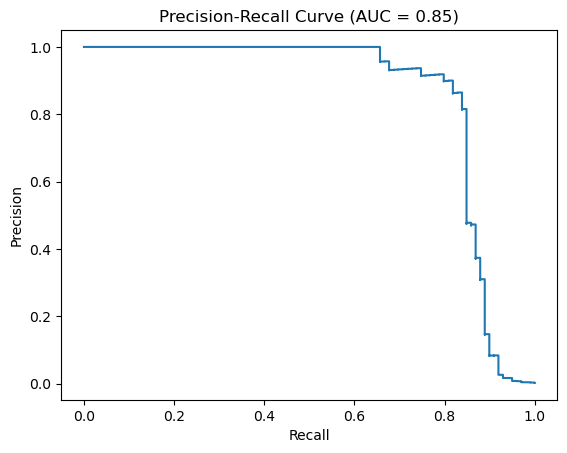

Area Under the Precision-Recall Curve (AUPRC): 0.85


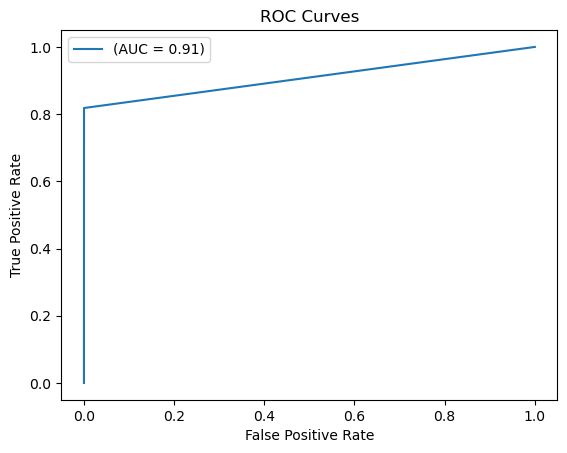

[[56880    11]
 [   18    81]]
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.88      0.82      0.85        99

    accuracy                           1.00     56990
   macro avg       0.94      0.91      0.92     56990
weighted avg       1.00      1.00      1.00     56990

0.6
[0]	validation_0-logloss:0.32643
[20]	validation_0-logloss:0.00958
[40]	validation_0-logloss:0.00364
[60]	validation_0-logloss:0.00335
[80]	validation_0-logloss:0.00345
[99]	validation_0-logloss:0.00360


<Figure size 800x600 with 0 Axes>

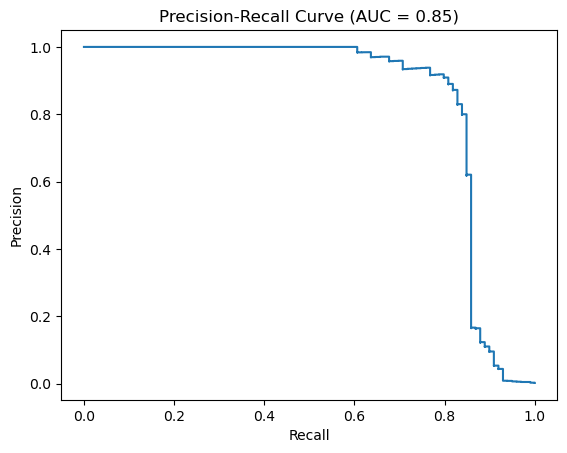

Area Under the Precision-Recall Curve (AUPRC): 0.85


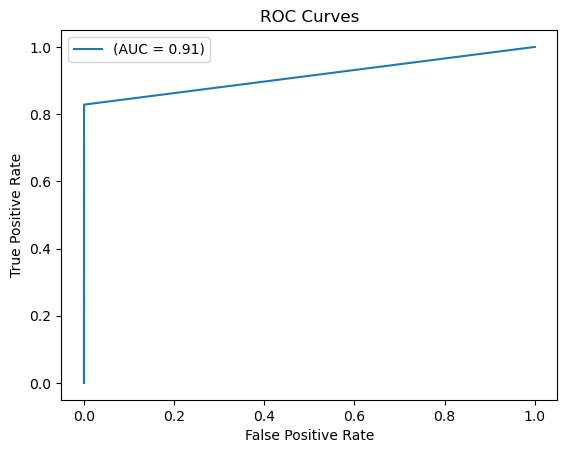

[[56879    12]
 [   17    82]]
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.87      0.83      0.85        99

    accuracy                           1.00     56990
   macro avg       0.94      0.91      0.92     56990
weighted avg       1.00      1.00      1.00     56990

0.7000000000000001
[0]	validation_0-logloss:0.36434
[20]	validation_0-logloss:0.00917
[40]	validation_0-logloss:0.00379
[60]	validation_0-logloss:0.00331
[80]	validation_0-logloss:0.00335
[99]	validation_0-logloss:0.00344


<Figure size 800x600 with 0 Axes>

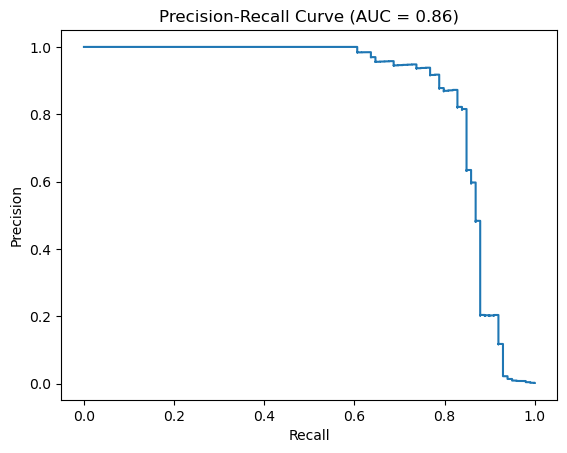

Area Under the Precision-Recall Curve (AUPRC): 0.86


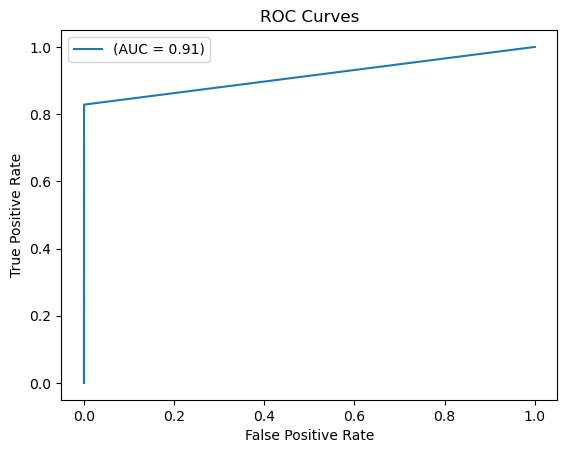

[[56879    12]
 [   17    82]]
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.87      0.83      0.85        99

    accuracy                           1.00     56990
   macro avg       0.94      0.91      0.92     56990
weighted avg       1.00      1.00      1.00     56990

0.8
[0]	validation_0-logloss:0.40082
[20]	validation_0-logloss:0.01100
[40]	validation_0-logloss:0.00422
[60]	validation_0-logloss:0.00351
[80]	validation_0-logloss:0.00363
[99]	validation_0-logloss:0.00375


<Figure size 800x600 with 0 Axes>

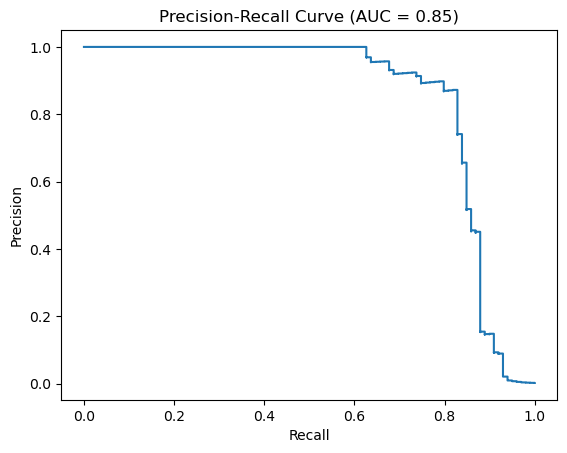

Area Under the Precision-Recall Curve (AUPRC): 0.85


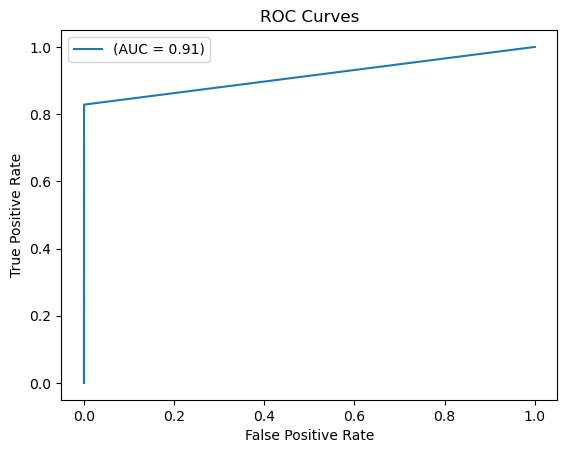

[[56879    12]
 [   17    82]]
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.87      0.83      0.85        99

    accuracy                           1.00     56990
   macro avg       0.94      0.91      0.92     56990
weighted avg       1.00      1.00      1.00     56990

0.9
[0]	validation_0-logloss:0.43323
[20]	validation_0-logloss:0.01236
[40]	validation_0-logloss:0.00421
[60]	validation_0-logloss:0.00348
[80]	validation_0-logloss:0.00350
[99]	validation_0-logloss:0.00360


<Figure size 800x600 with 0 Axes>

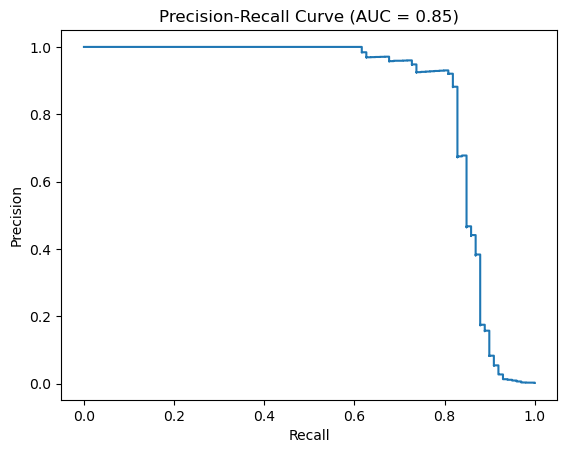

Area Under the Precision-Recall Curve (AUPRC): 0.85


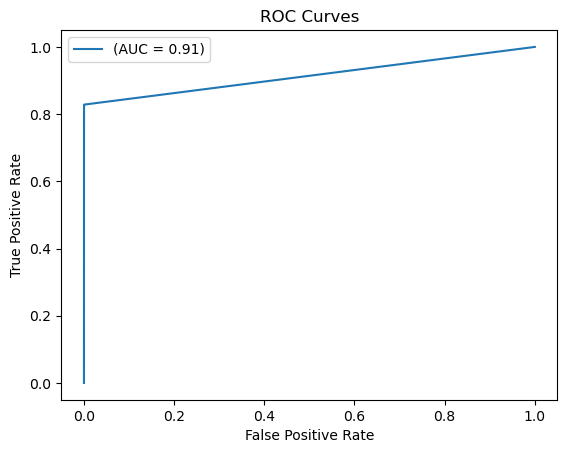

[[56878    13]
 [   17    82]]
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.86      0.83      0.85        99

    accuracy                           1.00     56990
   macro avg       0.93      0.91      0.92     56990
weighted avg       1.00      1.00      1.00     56990



In [94]:
dummy_df = pd.DataFrame()
for i in range(0, 9):
    print(0.1 + 0.1*i)
    desired_ratio = 0.1 + 0.1*i
    target_minority_count = int(counts[majority_class] * desired_ratio)
    sampling_strategy = {minority_class: target_minority_count}
    smote_enn2 = SMOTEENN(sampling_strategy= sampling_strategy, random_state=2908)
    X_smtnn2, y_smtnn2 = smote_enn2.fit_resample(X_train, y_train)

    X_val_smtnn2 = X_val.copy()

    X_smtnn2['Amount'] = scaler.fit_transform(X_smtnn2['Amount'].to_numpy().reshape(-1,1))
    X_val_smtnn2['Amount'] = scaler.transform(X_val_smtnn2['Amount'].to_numpy().reshape(-1,1))

    X_smtnn2['Time'] = scaler2.fit_transform(X_smtnn2['Time'].to_numpy().reshape(-1,1))
    X_val_smtnn2['Time'] = scaler2.transform(X_val_smtnn2['Time'].to_numpy().reshape(-1,1))

    dummy_df = add_res(dummy_df, round(desired_ratio, 2), X_smtnn2, X_val_smtnn2, y_smtnn2, y_val)

In [98]:
dummy_df.sort_values(by = 'aucprc', ascending= False)

,type,accuracy,Precision,Recall,F1 Score,auc,aucprc
0,0.7,0.999491,0.872340,0.828283,0.849741,0.914036,0.858058
0,0.5,0.999491,0.880435,0.818182,0.848168,0.908994,0.852432
0,0.3,0.999438,0.860215,0.808081,0.833333,0.903926,0.851871
0,0.9,0.999474,0.863158,0.828283,0.845361,0.914027,0.848908
0,0.1,0.999438,0.885057,0.777778,0.827957,0.888801,0.846730
0,0.8,0.999491,0.872340,0.828283,0.849741,0.914036,0.846656
0,0.6,0.999491,0.872340,0.828283,0.849741,0.914036,0.846261
0,0.2,0.999474,0.870968,0.818182,0.843750,0.908985,0.846016
0,0.4,0.999403,0.849462,0.797980,0.822917,0.898867,0.838083


Text(0, 0.5, 'value')

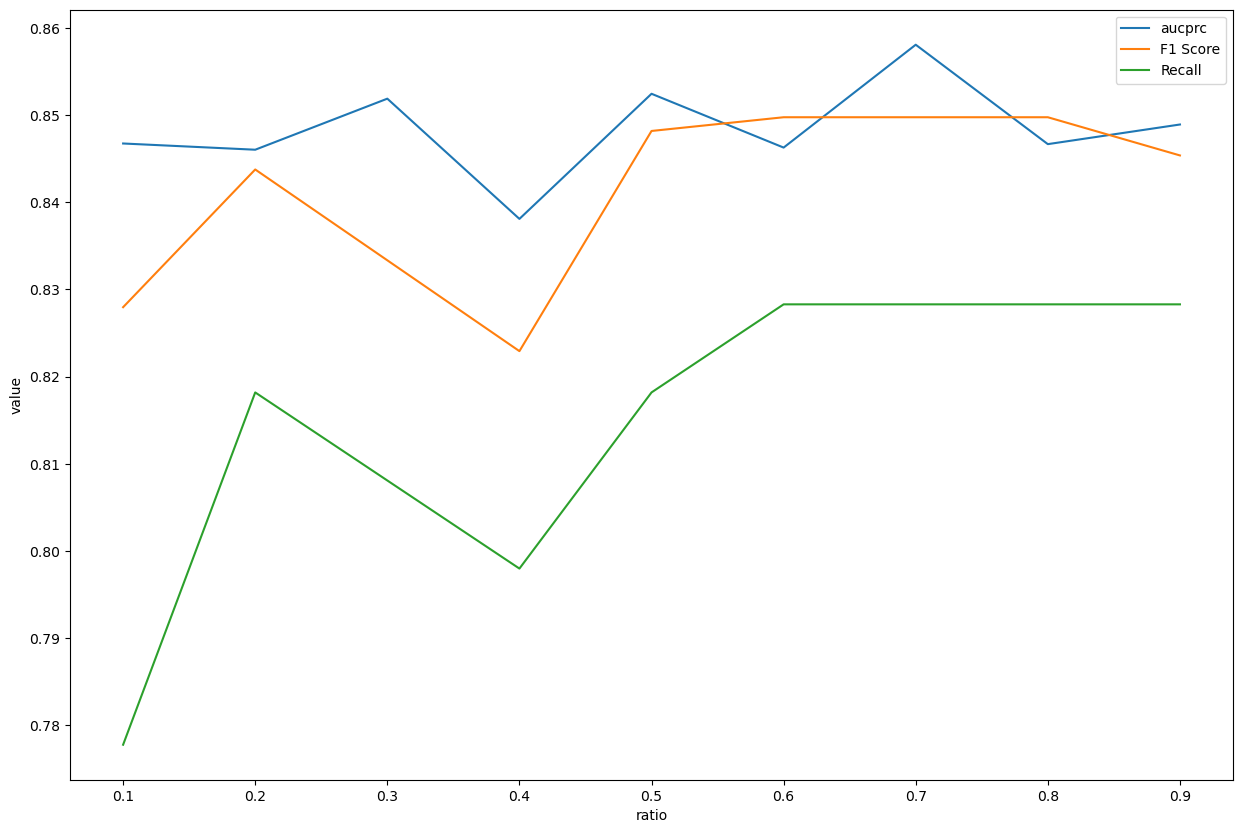

In [96]:
plt.figure(figsize= (15,10))
sns.lineplot(data= dummy_df, x = 'type', y = 'aucprc', label= 'aucprc')
sns.lineplot(data= dummy_df, x = 'type', y = 'F1 Score', label = 'F1 Score')
sns.lineplot(data= dummy_df, x = 'type', y = 'Recall', label = 'Recall')
plt.xlabel('ratio')
plt.ylabel('value')

best ratio is 0.7

[0]	validation_0-logloss:0.36434
[20]	validation_0-logloss:0.00917
[40]	validation_0-logloss:0.00379
[60]	validation_0-logloss:0.00331
[80]	validation_0-logloss:0.00335
[99]	validation_0-logloss:0.00344


<Figure size 800x600 with 0 Axes>

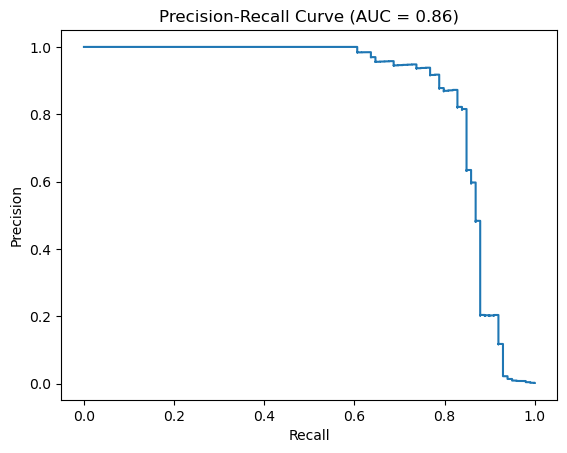

Area Under the Precision-Recall Curve (AUPRC): 0.86


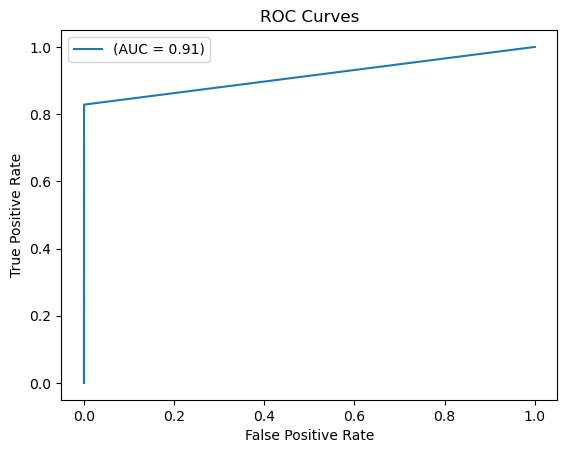

[[56879    12]
 [   17    82]]
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.87      0.83      0.85        99

    accuracy                           1.00     56990
   macro avg       0.94      0.91      0.92     56990
weighted avg       1.00      1.00      1.00     56990



,type,accuracy,Precision,Recall,F1 Score,auc,aucprc
0,original,0.999456,0.947368,0.727273,0.822857,0.863601,0.841697
1,undersample,0.949237,0.031208,0.939394,0.060409,0.944324,0.642091
2,oversample,0.999491,0.916667,0.777778,0.841530,0.888827,0.829314
3,smote,0.999491,0.872340,0.828283,0.849741,0.914036,0.849772
4,smotenn,0.999456,0.861702,0.818182,0.839378,0.908977,0.846537
6,smote_imb,0.999544,0.901099,0.828283,0.863158,0.914062,0.852963
0,smotenn_imb,0.999491,0.872340,0.828283,0.849741,0.914036,0.858058


In [99]:
desired_ratio = 0.7
target_minority_count = int(counts[majority_class] * desired_ratio)

sampling_strategy = {minority_class: target_minority_count}

smote_enn2 = SMOTEENN(sampling_strategy= sampling_strategy, random_state=2908)
X_smtnn2, y_smtnn2 = smote_enn2.fit_resample(X_train, y_train)

X_val_smtnn2 = X_val.copy()

X_smtnn2['Amount'] = scaler.fit_transform(X_smtnn2['Amount'].to_numpy().reshape(-1,1))
X_val_smtnn2['Amount'] = scaler.transform(X_val_smtnn2['Amount'].to_numpy().reshape(-1,1))

X_smtnn2['Time'] = scaler2.fit_transform(X_smtnn2['Time'].to_numpy().reshape(-1,1))
X_val_smtnn2['Time'] = scaler2.transform(X_val_smtnn2['Time'].to_numpy().reshape(-1,1))

res_df = add_res(res_df, 'smotenn_imb', X_smtnn2, X_val_smtnn2, y_smtnn2, y_val)
res_df

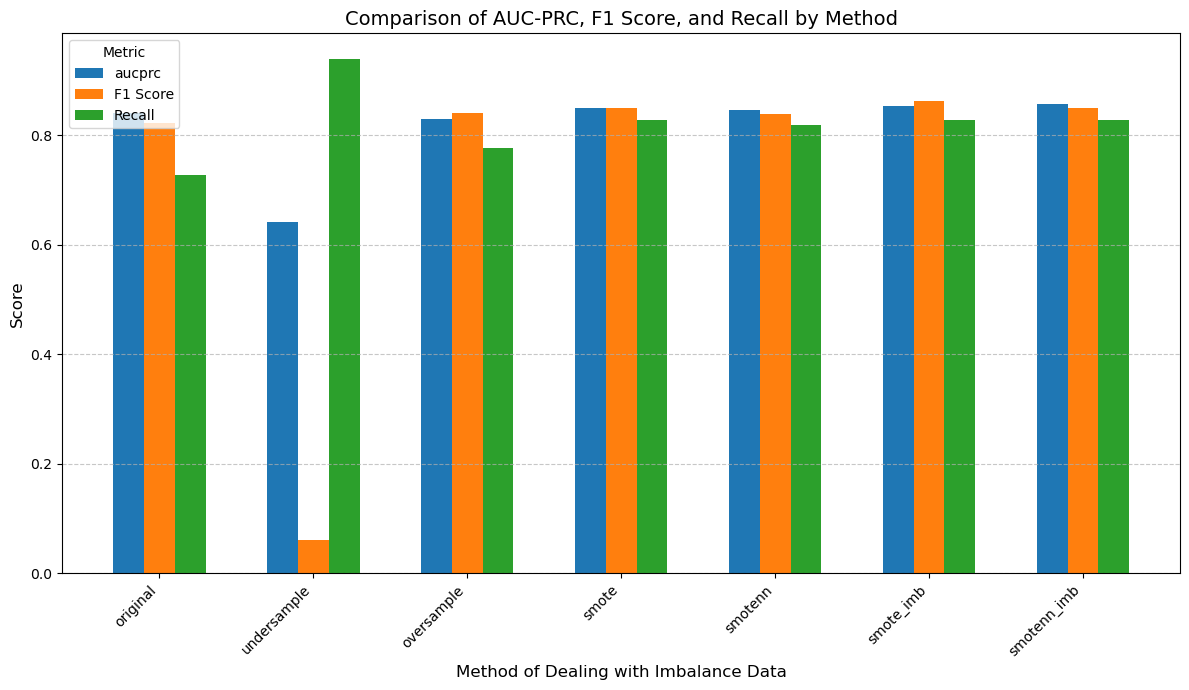

In [100]:
metrics_to_plot = ['aucprc', 'F1 Score', 'Recall']

num_methods = len(res_df['type'])
bar_width = 0.2
index = np.arange(num_methods)

fig, ax = plt.subplots(figsize=(12, 7))

for i, metric in enumerate(metrics_to_plot):
    offset = (i - (len(metrics_to_plot) - 1) / 2) * bar_width
    ax.bar(index + offset, res_df[metric], bar_width, label=metric)

ax.set_xlabel('Method of Dealing with Imbalance Data', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Comparison of AUC-PRC, F1 Score, and Recall by Method', fontsize=14)
ax.set_xticks(index)
ax.set_xticklabels(res_df['type'], rotation=45, ha='right')
ax.legend(title='Metric')
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

from the result table above, by comparing the recall, precision, F1 score, and aucprc, we are pretty happy with the result of smote_imb using smote_imb with ratio 0.2.

### final result (imbalance smote with ratio 0.2)

[0]	validation_0-logloss:0.17105
[10]	validation_0-logloss:0.01619
[20]	validation_0-logloss:0.00607
[30]	validation_0-logloss:0.00355
[40]	validation_0-logloss:0.00304
[50]	validation_0-logloss:0.00292
[60]	validation_0-logloss:0.00289
[70]	validation_0-logloss:0.00297
[80]	validation_0-logloss:0.00302
[90]	validation_0-logloss:0.00311
[99]	validation_0-logloss:0.00313


<Figure size 800x600 with 0 Axes>

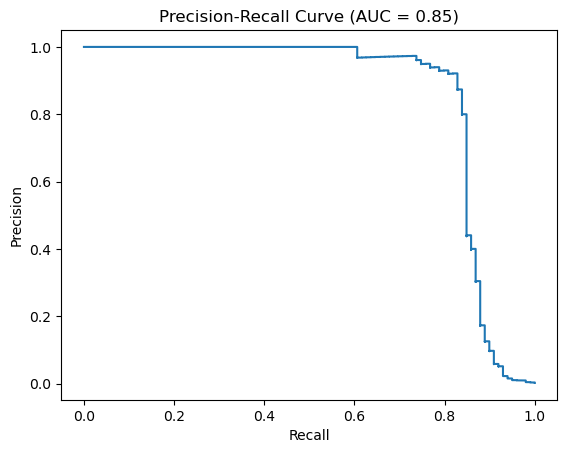

Area Under the Precision-Recall Curve (AUPRC): 0.85


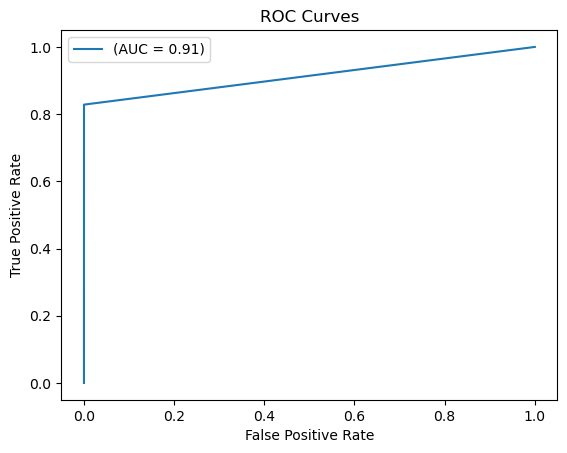

[[56882     9]
 [   17    82]]
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.90      0.83      0.86        99

    accuracy                           1.00     56990
   macro avg       0.95      0.91      0.93     56990
weighted avg       1.00      1.00      1.00     56990



In [ ]:
desired_ratio = 0.2

target_minority_count = int(counts[majority_class] * desired_ratio)
sampling_strategy = {minority_class: target_minority_count}

sm2 = SMOTE(sampling_strategy= sampling_strategy, random_state=2908)

X_smt2, y_smt2 = sm2.fit_resample(X_train, y_train)
y_smt2.value_counts()
X_val_smt2 = X_val.copy()
X_smt2['Amount'] = scaler.fit_transform(X_smt2['Amount'].to_numpy().reshape(-1,1))
X_val_smt2['Amount'] = scaler.transform(X_val_smt2['Amount'].to_numpy().reshape(-1,1))

X_smt2['Time'] = scaler2.fit_transform(X_smt2['Time'].to_numpy().reshape(-1,1))
X_val_smt2['Time'] = scaler2.transform(X_val_smt2['Time'].to_numpy().reshape(-1,1))

xgb = XGBClassifier(random_state = 2908)

xgb.fit(X_smt2, y_smt2, eval_set= [(X_val_smt2, y_val)], verbose=10)

y_pred = xgb.predict(X_val_smt2)
y_pred_prob = xgb.predict_proba(X_val_smt2)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)

<Figure size 800x600 with 0 Axes>

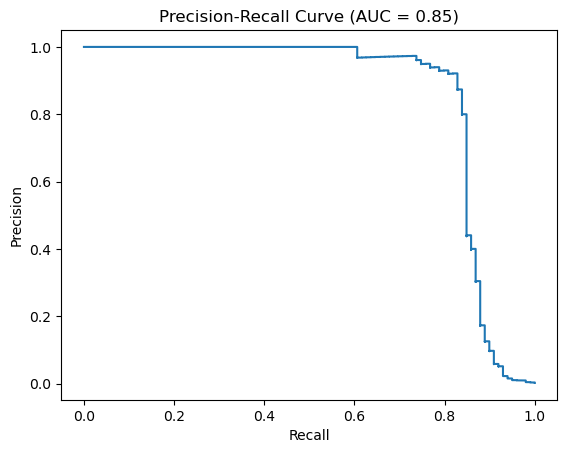

Area Under the Precision-Recall Curve (AUPRC): 0.85


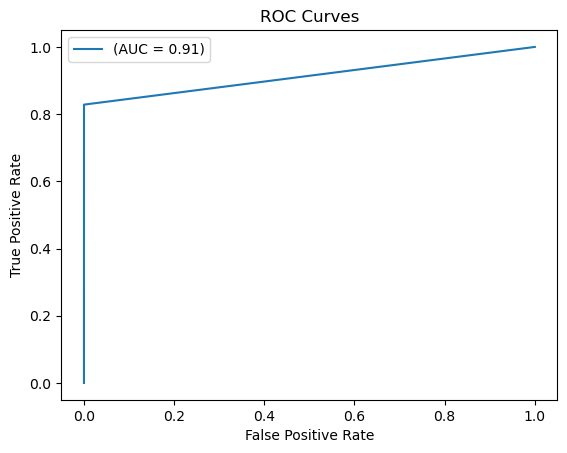

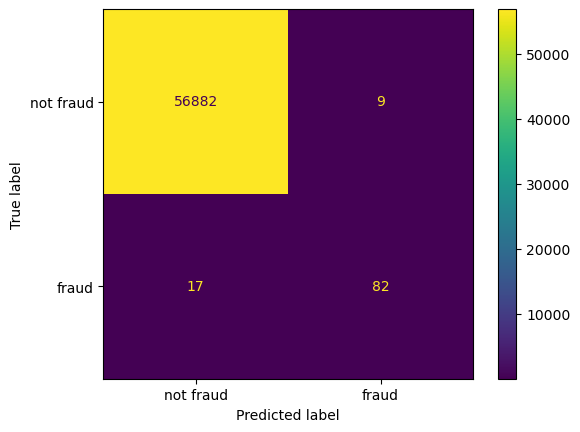

              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.90      0.83      0.86        99

    accuracy                           1.00     56990
   macro avg       0.95      0.91      0.93     56990
weighted avg       1.00      1.00      1.00     56990



In [106]:
plot_auprc(recall, precision)
plot_roc_auc(fpr,tpr)
cm = confusion_matrix(y_val, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['not fraud', 'fraud'])
cm_display.plot()
plt.show()

print(classification_report(y_val, y_pred, target_names = ['not fraud', 'fraud']))
auprc = auc(recall, precision)

# parameter tuning 

In [130]:
from sklearn.metrics import make_scorer

average_precision = make_scorer(average_precision_score, needs_proba=True)


def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'eval_metric': 'aucpr'
    }

    model = XGBClassifier(**params, random_state = 2908)
    score = cross_val_score(model, X_smt2, y_smt2, cv=3, scoring=average_precision).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best trial:")
print(study.best_trial.params)

[I 2025-05-23 17:41:07,039] A new study created in memory with name: no-name-518481f9-e456-4ba7-b540-ff137dcbc437


[I 2025-05-23 17:41:15,268] Trial 0 finished with value: 0.9999093755104985 and parameters: {'n_estimators': 346, 'max_depth': 5, 'learning_rate': 0.23205574531419332, 'subsample': 0.9681292024258865, 'colsample_bytree': 0.5055800950487257, 'gamma': 2.0125861417741744, 'min_child_weight': 8, 'reg_alpha': 0.16008884741790097, 'reg_lambda': 0.7563765661643251}. Best is trial 0 with value: 0.9999093755104985.
[I 2025-05-23 17:41:21,893] Trial 1 finished with value: 0.9998362446713256 and parameters: {'n_estimators': 318, 'max_depth': 9, 'learning_rate': 0.13875419626285976, 'subsample': 0.6795646231929332, 'colsample_bytree': 0.7521907366068449, 'gamma': 4.899478766449481, 'min_child_weight': 3, 'reg_alpha': 0.37720457435578303, 'reg_lambda': 0.9213174105011769}. Best is trial 0 with value: 0.9999093755104985.
[I 2025-05-23 17:41:27,965] Trial 2 finished with value: 0.9999176328389496 and parameters: {'n_estimators': 212, 'max_depth': 4, 'learning_rate': 0.19013870711287476, 'subsample': 

Best trial:
{'n_estimators': 592, 'max_depth': 9, 'learning_rate': 0.07936445155506858, 'subsample': 0.6308314099892454, 'colsample_bytree': 0.7329818406404794, 'gamma': 0.24131371703233095, 'min_child_weight': 6, 'reg_alpha': 0.01315924731291318, 'reg_lambda': 0.341505501547371}


Best trial:
{'n_estimators': 610, 'max_depth': 4, 'learning_rate': 0.12258402266674268, 'subsample': 0.9592932030299457, 'colsample_bytree': 0.7237404914600087, 'gamma': 0.029103087549269123, 'min_child_weight': 4, 'reg_alpha': 0.6456724328045081, 'reg_lambda': 0.28952854695841174}

{'n_estimators': 592, 'max_depth': 9, 'learning_rate': 0.07936445155506858, 'subsample': 0.6308314099892454, 'colsample_bytree': 0.7329818406404794, 'gamma': 0.24131371703233095, 'min_child_weight': 6, 'reg_alpha': 0.01315924731291318, 'reg_lambda': 0.341505501547371}




In [131]:
best_params = {'n_estimators': 592, 
               'max_depth': 9, 
               'learning_rate': 0.07936445155506858, 
               'subsample': 0.6308314099892454, 
               'colsample_bytree': 0.7329818406404794, 
               'gamma': 0.24131371703233095, 
               'min_child_weight': 6, 
               'reg_alpha': 0.01315924731291318, 
               'reg_lambda': 0.341505501547371}

xgb_tuned = XGBClassifier(**best_params, eval_metric = 'aucpr', random_state = 2908)

xgb_tuned.fit(X_smt2, y_smt2, eval_set= [(X_val_smt2, y_val)], verbose=10)

y_pred_tuned = xgb.predict(X_val_smt2)
y_pred_prob_tuned = xgb.predict_proba(X_val_smt2)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_tuned)
precision, recall, _ = precision_recall_curve(y_val, y_pred_prob_tuned)

[0]	validation_0-aucpr:0.68572
[10]	validation_0-aucpr:0.74570
[20]	validation_0-aucpr:0.77800
[30]	validation_0-aucpr:0.81685
[40]	validation_0-aucpr:0.83602
[50]	validation_0-aucpr:0.84350
[60]	validation_0-aucpr:0.84355
[70]	validation_0-aucpr:0.84867
[80]	validation_0-aucpr:0.84955
[90]	validation_0-aucpr:0.84967
[100]	validation_0-aucpr:0.85013
[110]	validation_0-aucpr:0.85134
[120]	validation_0-aucpr:0.85140
[130]	validation_0-aucpr:0.85113
[140]	validation_0-aucpr:0.85295
[150]	validation_0-aucpr:0.85286
[160]	validation_0-aucpr:0.85354
[170]	validation_0-aucpr:0.85371
[180]	validation_0-aucpr:0.85412
[190]	validation_0-aucpr:0.85266
[200]	validation_0-aucpr:0.85278
[210]	validation_0-aucpr:0.85195
[220]	validation_0-aucpr:0.85185
[230]	validation_0-aucpr:0.85214
[240]	validation_0-aucpr:0.85214
[250]	validation_0-aucpr:0.85319
[260]	validation_0-aucpr:0.85250
[270]	validation_0-aucpr:0.85275
[280]	validation_0-aucpr:0.85325
[290]	validation_0-aucpr:0.85340
[300]	validation_0-au

<Figure size 800x600 with 0 Axes>

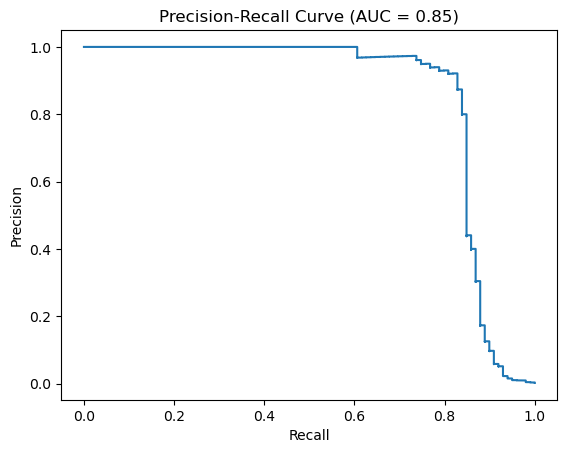

Area Under the Precision-Recall Curve (AUPRC): 0.85


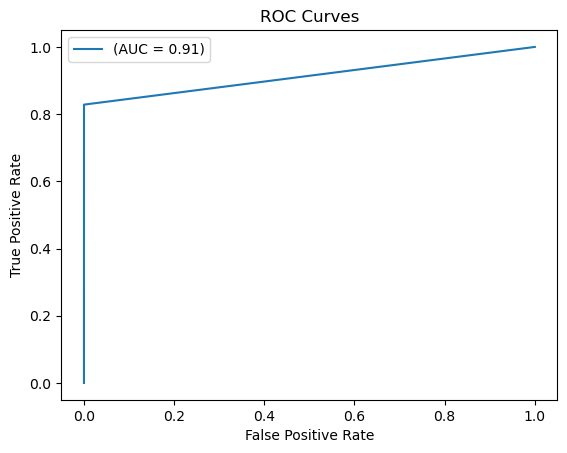

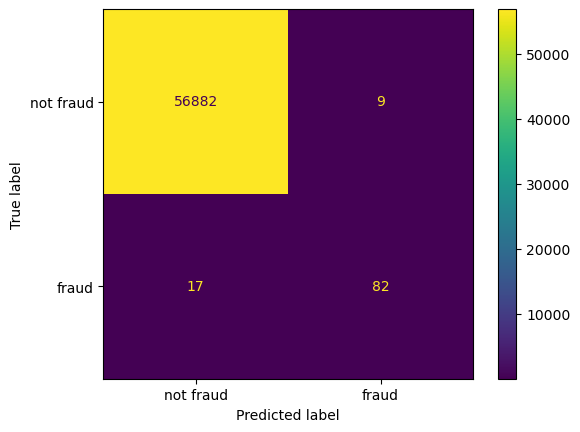

              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.90      0.83      0.86        99

    accuracy                           1.00     56990
   macro avg       0.95      0.91      0.93     56990
weighted avg       1.00      1.00      1.00     56990

Precision: 0.9010989010989011
Recall: 0.8282828282828283
F1 Score: 0.8631578947368421
AUC : 0.9140623155142147
aucpr 0.8529631999887471


In [132]:
plot_auprc(recall, precision)
plot_roc_auc(fpr,tpr)
cm = confusion_matrix(y_val, y_pred_tuned)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['not fraud', 'fraud'])
cm_display.plot()
plt.show()

print(classification_report(y_val, y_pred_tuned, target_names = ['not fraud', 'fraud']))
auprc = auc(recall, precision)

print("Precision:", precision_score(y_val, y_pred_tuned))
# Recall: TP/(TP+FN)
print("Recall:", recall_score(y_val, y_pred_tuned))
# F1 Score: 2*recall*precision/(recall+precision) ie. balance between precision and recall
print("F1 Score:", f1_score(y_val, y_pred_tuned))
print("AUC :", auc(fpr, tpr))
print('aucpr', auprc)

In [118]:
res_df

,type,accuracy,Precision,Recall,F1 Score,auc,aucprc
0,original,0.999456,0.947368,0.727273,0.822857,0.863601,0.841697
1,undersample,0.949237,0.031208,0.939394,0.060409,0.944324,0.642091
2,oversample,0.999491,0.916667,0.777778,0.841530,0.888827,0.829314
3,smote,0.999491,0.872340,0.828283,0.849741,0.914036,0.849772
4,smotenn,0.999456,0.861702,0.818182,0.839378,0.908977,0.846537
6,smote_imb,0.999544,0.901099,0.828283,0.863158,0.914062,0.852963
0,smotenn_imb,0.999491,0.872340,0.828283,0.849741,0.914036,0.858058
